In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/TIDLLM

/content/drive/MyDrive/TIDLLM


In [3]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)


### Importing Libraries

In [30]:
import os
import cv2
import sys
import glob
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib.pylab import plt
from numpy import arange

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from vector_quantize_pytorch import VectorQuantize, ResidualVQ

from lib.config import *
from lib.encoder.vqvae import VQVAE
from lib.utils.pose import get_pose_estimation
from lib.encoder.ffn import FFNEncoder, FFNDecoder
from lib.encoder.cnn3d import CNN3DEncoder, CNN3DDecoder
from lib.data.dataset import PoseDataset, PoseDistanceDataset
from lib.train.run_autoencoder_training import AutoencoderTrainer

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
Tesla V100-SXM2-16GB


### 1. Pose Inference

In [8]:
SAMPLE = 'dataset/corpus/ABARTMAK_0.mp4'
SAMPLE_POSE = get_pose_estimation(SAMPLE)

In [9]:
def get_pose_array(SAMPLE_POSE):
    """
    Converts the pose data into a numpy array
    """

    POSE_RAW = pd.DataFrame(SAMPLE_POSE['pose'])
    RIGHT_HAND_RAW = pd.DataFrame(SAMPLE_POSE['right'])
    LEFT_HAND_RAW = pd.DataFrame(SAMPLE_POSE['left'])

    POSE_DF = {}

    for col in POSE_RAW.columns:
        POSE_DF[ 'POSE_' + col + '_X'] = POSE_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'POSE_' + col + '_Y'] = POSE_RAW[col].apply(lambda x: x[1])
        # POSE_DF[ 'POSE_' + col + '_Z'] = POSE_RAW[col].apply(lambda x: x[2])
        # POSE_DF[col + '_viz'] = POSE_RAW[col].apply(lambda x: x[3])

    for col in RIGHT_HAND_RAW.columns:
        POSE_DF[ 'RIGHT_' + col + '_X' ] = RIGHT_HAND_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'RIGHT_' + col + '_Y' ] = RIGHT_HAND_RAW[col].apply(lambda x: x[1])
        # POSE_DF[ 'RIGHT_' + col + '_Z' ] = RIGHT_HAND_RAW[col].apply(lambda x: x[2])
        # POSE_DF['RIGHT_' + col + '_viz'] = RIGHT_HAND_RAW[col].apply(lambda x: x[3])

    for col in LEFT_HAND_RAW.columns:
        POSE_DF[ 'LEFT_' + col + '_X' ] = LEFT_HAND_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'LEFT_' + col + '_Y' ] = LEFT_HAND_RAW[col].apply(lambda x: x[1])
        # POSE_DF[ 'LEFT_' + col + '_Z' ] = LEFT_HAND_RAW[col].apply(lambda x: x[2])
        # POSE_DF['LEFT_' + col + '_viz'] = LEFT_HAND_RAW[col].apply(lambda x: x[3])

    POSE_DF = pd.DataFrame(POSE_DF)

    return POSE_DF

In [10]:
POSE_DF = get_pose_array(SAMPLE_POSE[0]) # SAMPLE_POSE["pose"]

In [11]:
POSE_DF.head(10)

,POSE_NOSE_X,POSE_NOSE_Y,POSE_LEFT_EYE_INNER_X,POSE_LEFT_EYE_INNER_Y,POSE_LEFT_EYE_X,POSE_LEFT_EYE_Y,POSE_LEFT_EYE_OUTER_X,POSE_LEFT_EYE_OUTER_Y,POSE_RIGHT_EYE_INNER_X,POSE_RIGHT_EYE_INNER_Y,...,LEFT_RING_FINGER_TIP_X,LEFT_RING_FINGER_TIP_Y,LEFT_PINKY_MCP_X,LEFT_PINKY_MCP_Y,LEFT_PINKY_PIP_X,LEFT_PINKY_PIP_Y,LEFT_PINKY_DIP_X,LEFT_PINKY_DIP_Y,LEFT_PINKY_TIP_X,LEFT_PINKY_TIP_Y
0,0.469806,0.242606,0.487051,0.204420,0.496914,0.203189,0.506662,0.202956,0.454303,0.211295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.470035,0.242358,0.487213,0.204480,0.497720,0.203515,0.507534,0.203520,0.454288,0.210316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470407,0.242079,0.487484,0.204492,0.498458,0.203672,0.508245,0.203822,0.454288,0.209339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.470645,0.241855,0.487634,0.204496,0.498899,0.203771,0.508677,0.204023,0.454282,0.208659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.470878,0.241824,0.487784,0.204503,0.499225,0.203839,0.508947,0.204135,0.454281,0.208279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.469955,0.242016,0.486899,0.204655,0.498503,0.204091,0.508513,0.204423,0.453695,0.208283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.468617,0.242897,0.485244,0.205087,0.497028,0.204452,0.507402,0.204712,0.452599,0.208908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.468346,0.243676,0.484669,0.205550,0.496354,0.204834,0.506824,0.205038,0.451937,0.209324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.464956,0.247380,0.480842,0.208866,0.492176,0.207660,0.502795,0.207422,0.449240,0.213016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.462591,0.251390,0.477768,0.213662,0.488384,0.212251,0.499159,0.211541,0.446978,0.217970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print("Shape:", POSE_DF.shape) # 54 frame in a sample video and 225 landmark.
print("Number of NaN values:", POSE_DF.isnull().sum().sum()) # 54x225 = 12.150 - but 1764 are null.
# Fill NaN values with 0.
POSE_DF = POSE_DF.replace(np.nan,0)
print(f"After filling NaN values with zero, we have {POSE_DF.isnull().sum().sum()} NaN values.")

Shape: (54, 150)
Number of NaN values: 0
After filling NaN values with zero, we have 0 NaN values.


In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


### 2- VQ-VAE with FFN Training

In [ ]:
DATA_PATH = 'dataset/pose/'
data = glob.glob(DATA_PATH + '*.npy')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Train and validation datasets

train_dataset = PoseDataset(X_train)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=GLOBAL_CONFIG.BATCH_SIZE,
    shuffle=True,
)

val_dataset = PoseDataset(X_val)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=GLOBAL_CONFIG.BATCH_SIZE,
    shuffle=True,
)

100%|██████████| 679/679 [00:01<00:00, 345.65it/s]


In [ ]:
MODEL_ENCODER = FFNEncoder(
    input_dim=GLOBAL_CONFIG.MODEL_ENCODER_INPUT_DIM,
    hidden_dim=GLOBAL_CONFIG.MODEL_ENCODER_HIDDEN_DIM,
    output_dim=GLOBAL_CONFIG.MODEL_ENCODER_OUTPUT_DIM,
)

MODEL_DECODER = FFNDecoder(
    input_dim=GLOBAL_CONFIG.MODEL_DECODER_INPUT_DIM,
    hidden_dim=GLOBAL_CONFIG.MODEL_DECODER_HIDDEN_DIM,
    output_dim=GLOBAL_CONFIG.MODEL_ENCODER_INPUT_DIM,
)

MODEL_QUANT = VectorQuantize(
    dim = GLOBAL_CONFIG.MODEL_VQ_EMBED_DIM,
    stochastic_sample_codes=True, # When set to True, the model may sample codes randomly instead of using the nearest centroid during quantization.
    #num_quantizers=1,      # specify number of quantizers
    codebook_size=512,  # codebook size
    kmeans_init=True,   # set to True
    kmeans_iters=100, # number of kmeans iterations to calculate the centroids for the codebook on init
    threshold_ema_dead_code = 2,
)

MODEL_VQVAE = VQVAE(
    encoder=MODEL_ENCODER,
    decoder=MODEL_DECODER,
    vq=MODEL_QUANT,
)

trainer = AutoencoderTrainer(
    model=MODEL_VQVAE,
    learning_rate=GLOBAL_CONFIG.LEARNING_RATE,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=25,
    device=DEVICE,
)

In [ ]:
trainer.train()

In [ ]:
MODEL_VQVAE.eval()

dfs = []
for train_sample in tqdm(train_dataloader):
    with torch.no_grad():
        quantized, indices, commitment_loss = MODEL_VQVAE(train_sample['array'].to(DEVICE).float())
        dfs.append(pd.DataFrame({
            'videos': train_sample['token'],
            'labels': indices.detach().cpu().numpy().reshape(-1),
            'frame': train_sample['frame'].detach().cpu().numpy().reshape(-1)
        }))

100%|██████████| 18907/18907 [00:33<00:00, 565.37it/s]


In [ ]:
df = pd.concat(dfs)

In [ ]:
df.head(10)

,videos,labels,frame
0,DU╠êZELMEK_0.npy,1,32
1,TERS_1.npy,7,35
2,BU╠êTU╠êN_1.npy,1,20
3,BO╠êBREK_0.npy,6,21
4,MEZAR_0.npy,4,10
5,ONAY_0.npy,6,8
6,AG╠åRITMAK_1.npy,4,15
7,BULUS╠ğMAK_1.npy,4,36
0,SOKAK_2.npy,6,5
1,NAMAZ_0.npy,6,2


In [ ]:
df.labels.value_counts()

labels
6     69556
4     19105
2     16981
0     13640
1      9705
55     8424
7      7234
10     6609
Name: count, dtype: int64

In [ ]:
sample_label = 55

for rec in tqdm(df[df['labels'] == sample_label].to_dict(orient='records')[:100]):
    # save frame video to disk
    video = rec['videos'].split('.')[0]
    video_path = f"dataset/corpus/{video}.mp4"
    frame_idx = rec['frame']
    label = rec['labels']

    cap = cv2.VideoCapture(video_path)
    #ret, frame = cap.read()

    if not os.path.exists(f'analyze/quantization/{label}'):
      os.mkdir(f'analyze/quantization/{label}')

    for i in range(frame_idx):
        ret, frame = cap.read()
        if i == frame_idx-1:
            cv2.imwrite(f'analyze/quantization/{label}/{video}_{frame_idx}.jpg', frame)


100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


### 3- Preparation for Graph Autoencoder

In [14]:
def get_difference_matrix(row):
    """
    Get differences
    """
    m, n = np.meshgrid(row, row)
    out = m-n
    return out


def get_matrices(POSE_DF):
    """
    Converts the pose data into a numpy array of distance matrices
    """

    x_cols = [col for col in POSE_DF.columns if col.endswith('_X')]
    y_cols = [col for col in POSE_DF.columns if col.endswith('_Y')]

    frames = []

    for i in range(1, POSE_DF.shape[0]):
        x_row = POSE_DF[x_cols].iloc[i].to_numpy()
        y_row = POSE_DF[y_cols].iloc[i].to_numpy()

        x_diff = get_difference_matrix(x_row)
        y_diff = get_difference_matrix(y_row)

        frame = np.stack([x_diff, y_diff], axis=2)
        frames.append(frame)

    frames = np.stack(frames, axis=0)
    return x_diff, y_diff, frames

In [13]:
# If you run once this, we'll save the files.
# You don't need to run again.
# You can find files in OUT_PATH
OUT_PATH = 'dataset/adjacency'
POSE_PATH = 'dataset/features'

for file in tqdm(glob.glob('dataset/features/*.npy')):
    if os.path.exists(os.path.join(OUT_PATH, os.path.basename(file).replace('.mp4', '.npy'))):
        # print('Skipping', file)
        continue
    with open(file, 'rb') as f:
        array = np.load(f, allow_pickle=True)
        array = np.nan_to_num(array)

    pose_df = pd.DataFrame(array, columns=POSE_DF.columns)
    pose_df = pose_df.replace(np.nan, 0)
    x_diff, y_diff, MATRICES = get_matrices(pose_df)

    np.save(os.path.join(OUT_PATH, os.path.basename(file).replace('.mp4', '.npy')), MATRICES)


100%|██████████| 3415/3415 [00:19<00:00, 172.73it/s]


In [ ]:
print(pd.DataFrame(x_diff, columns=[col for col in POSE_DF.columns if col.endswith('_X')], index=[col for col in POSE_DF.columns if col.endswith('_X')]).to_markdown())

NameError: name 'x_diff' is not defined

In [ ]:
import glob
import numpy as np
from tqdm.notebook import tqdm
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ARRAY_PATH = 'dataset/features/'
    for datapath in tqdm(glob.glob('dataset/corpus/*.mp4')):
        print(datapath)
        pose, _ = get_pose_estimation(datapath)
        pose_array = get_pose_array(pose)
        print(pose_array.shape, datapath)
        dname = datapath.split('/')[-1].replace('.mp4', '.npy')
        with open(ARRAY_PATH+'/'+dname, 'wb') as f:
            np.save(f, pose_array)

  0%|          | 0/3395 [00:00<?, ?it/s]

dataset/corpus/KURT_0.mp4
(50, 150) dataset/corpus/KURT_0.mp4
dataset/corpus/OMUZ_0.mp4
(76, 150) dataset/corpus/OMUZ_0.mp4
dataset/corpus/PU╠êRE_2.mp4


KeyboardInterrupt: 

###  4- 3D-CNN Training

In [21]:
DATA_PATH = 'dataset/adjacency/'
data = glob.glob(DATA_PATH + '*.npy')[:100]
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [22]:
train_dataset = PoseDistanceDataset(X_train)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=GLOBAL_CONFIG.BATCH_SIZE,
    shuffle=True,
    collate_fn=PoseDistanceDataset.collate_fn
)

100%|██████████| 80/80 [00:36<00:00,  2.22it/s]


In [23]:
val_dataset = PoseDistanceDataset(X_val)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=GLOBAL_CONFIG.BATCH_SIZE,
    shuffle=True,
    collate_fn=PoseDistanceDataset.collate_fn
)

100%|██████████| 20/20 [00:00<00:00, 58.37it/s]


In [24]:
for i, images in enumerate(train_dataloader):
    print(images["array"].shape)
    break

torch.Size([8, 2, 5, 75, 75])


In [25]:
MODEL_ENCODER = CNN3DEncoder(
    input_channels=2,
)

MODEL_DECODER = CNN3DDecoder(
    output_channels=2,
)

MODEL_QUANT = ResidualVQ(
    dim = GLOBAL_CONFIG.MODEL_VQ_EMBED_DIM,
    stochastic_sample_codes=True,
    num_quantizers=1,      # specify number of quantizers
    codebook_size=GLOBAL_CONFIG.MODEL_VQ_NUM_EMBS,    # codebook size
    kmeans_init=True,   # set to True
    kmeans_iters=10     # number of kmeans iterations to calculate the centroids for the codebook on init
)

MODEL_VQVAE = VQVAE(
    encoder=MODEL_ENCODER,
    decoder=MODEL_DECODER,
    vq=MODEL_QUANT,
)

trainer = AutoencoderTrainer(
    model=MODEL_VQVAE,
    learning_rate=GLOBAL_CONFIG.LEARNING_RATE,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=GLOBAL_CONFIG.NUM_EPOCHS,
    device=DEVICE,
)

In [26]:
recon_train_loss, commit_train_loss, recon_val_loss, commit_val_loss = trainer.train()

  1%|          | 1/100 [00:39<1:05:07, 39.47s/it]


    ***
    Epoch:1, 
    Train Commitment Loss: 0.26242942794905844, 
    Train Reconstruction Loss: 145.57193215191364, 
    Train Quantization Tokens:
    |       |   326 |   953 |   621 |   486 |   833 |   705 |   992 |   128 |   25 |   653 |   222 |   462 |   498 |   609 |   897 |   259 |   407 |   899 |   881 |   692 |   106 |   396 |   878 |   9 |   94 |   95 |   968 |   844 |   510 |   963 |   768 |   570 |   280 |   855 |   155 |   804 |   761 |   386 |   171 |   670 |   861 |   359 |   563 |   835 |   893 |   35 |   342 |   807 |   851 |   63 |   147 |   158 |   863 |   275 |   125 |   769 |   960 |   102 |   598 |   379 |   800 |   378 |   747 |   75 |   796 |   470 |   562 |   605 |   225 |   602 |   66 |   352 |   274 |   659 |   919 |   30 |   107 |   749 |   734 |   108 |   263 |   993 |   882 |   972 |   282 |   199 |   324 |   8 |   859 |   567 |   443 |   184 |   299 |   451 |   256 |   109 |   350 |   194 |   775 |   950 |   660 |   89 |   947 |   11 |   215 |   962

  2%|▏         | 2/100 [01:18<1:03:58, 39.17s/it]


    ***
    Epoch:2, 
    Train Commitment Loss: 1.3669089728209656, 
    Train Reconstruction Loss: 109.99609066545963, 
    Train Quantization Tokens:
    |       |   474 |   970 |   206 |   87 |   75 |   698 |   491 |   815 |   692 |   542 |   157 |   97 |   424 |   690 |   807 |   499 |   20 |   396 |   647 |   535 |   103 |   405 |   288 |   64 |   556 |   264 |   164 |   836 |   187 |   635 |   397 |   658 |   238 |   579 |   823 |   226 |   512 |   938 |   485 |   694 |   628 |   412 |   35 |   118 |   27 |   719 |   858 |   715 |   361 |   787 |   77 |   111 |   304 |   363 |   125 |   410 |   660 |   603 |   779 |   613 |   312 |   24 |   845 |   229 |   2 |   341 |   37 |   989 |   678 |   675 |   440 |   490 |   903 |   156 |   966 |   232 |   559 |   314 |   973 |   109 |   416 |   458 |   44 |   597 |   621 |   336 |   759 |   587 |   677 |   799 |   104 |   707 |   949 |   536 |   808 |   850 |   676 |   706 |   131 |   980 |   979 |   287 |   883 |   197 |   49 |   464 

  3%|▎         | 3/100 [01:57<1:03:27, 39.25s/it]


    ***
    Epoch:3, 
    Train Commitment Loss: 1.0644344530883245, 
    Train Reconstruction Loss: 91.68439453840256, 
    Train Quantization Tokens:
    |       |   75 |   474 |   698 |   64 |   815 |   97 |   87 |   157 |   542 |   970 |   491 |   206 |   238 |   647 |   807 |   658 |   20 |   397 |   103 |   164 |   556 |   836 |   288 |   424 |   692 |   499 |   535 |   635 |   264 |   396 |   405 |   690 |
|:------|-----:|------:|------:|-----:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |  194 |   193 |   185 |  178 |   170 |  170 |  162 |   160 |   159 |   159 |   153 |   117 |   112 |   107 |   104 |    99 |   99 |    99 |    98 |    95 |    92 |    91 |    90 |    88 |    84 |    80 |    77 |    68 |    66 |    58 |    47 |     6 |, 

    Validation Commitment Loss: 0.2394042426312808,
    V

  4%|▍         | 4/100 [02:36<1:02:20, 38.96s/it]


    ***
    Epoch:4, 
    Train Commitment Loss: 1.0575883346609771, 
    Train Reconstruction Loss: 90.00232164561749, 
    Train Quantization Tokens:
    |       |   75 |   491 |   698 |   97 |   64 |   542 |   815 |   474 |   157 |   970 |   87 |   836 |   397 |   164 |   499 |   807 |   405 |   396 |   647 |   424 |   535 |   20 |   103 |   658 |   238 |   635 |   288 |
|:------|-----:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |  204 |   189 |   188 |  178 |  176 |   172 |   169 |   161 |   161 |   152 |  144 |   144 |   141 |   137 |   131 |   129 |   125 |   121 |   116 |   112 |   111 |  110 |   103 |    92 |    81 |    77 |    36 |, 

    Validation Commitment Loss: 0.2806854934315197,
    Validation Reconstruction Loss: 18.705263651907444,
    Validation Quantization Tokens:
    |       |   405 |   103 |   4

  5%|▌         | 5/100 [03:15<1:01:56, 39.12s/it]


    ***
    Epoch:5, 
    Train Commitment Loss: 1.024020088429097, 
    Train Reconstruction Loss: 89.55825987458229, 
    Train Quantization Tokens:
    |       |   424 |   542 |   405 |   75 |   647 |   97 |   20 |   658 |   815 |   157 |   836 |   970 |   807 |   474 |   238 |   164 |   491 |   87 |   499 |   396 |   103 |   397 |   64 |   535 |   698 |
|:------|------:|------:|------:|-----:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|
| count |   209 |   194 |   190 |  189 |   178 |  172 |  171 |   170 |   167 |   165 |   164 |   155 |   154 |   153 |   152 |   147 |   145 |  143 |   129 |   123 |   116 |   105 |   96 |    49 |    24 |, 

    Validation Commitment Loss: 0.2640038718818687,
    Validation Reconstruction Loss: 18.65101784467697,
    Validation Quantization Tokens:
    |       |   397 |   164 |   658 |   424 |   647 |   535 |   970 |   103 |   405

  6%|▌         | 6/100 [03:54<1:01:09, 39.04s/it]


    ***
    Epoch:6, 
    Train Commitment Loss: 1.090765480097616, 
    Train Reconstruction Loss: 89.27253520488739, 
    Train Quantization Tokens:
    |       |   658 |   970 |   405 |   397 |   97 |   64 |   647 |   75 |   491 |   238 |   396 |   87 |   424 |   542 |   807 |   164 |   815 |   499 |   474 |   836 |   157 |   20 |   535 |   103 |
|:------|------:|------:|------:|------:|-----:|-----:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   185 |   180 |   177 |   175 |  174 |  172 |   171 |  164 |   163 |   161 |   159 |  156 |   155 |   154 |   154 |   153 |   148 |   147 |   142 |   140 |   128 |  125 |   113 |    64 |, 

    Validation Commitment Loss: 0.23992476286366582,
    Validation Reconstruction Loss: 18.551044031977654,
    Validation Quantization Tokens:
    |       |   836 |   647 |   424 |   658 |   970 |   64 |   97 |   405 |   535 |   75 |   397 |   87 |

  7%|▋         | 7/100 [04:33<1:00:25, 38.98s/it]


    ***
    Epoch:7, 
    Train Commitment Loss: 1.0325831365480553, 
    Train Reconstruction Loss: 89.0934480279684, 
    Train Quantization Tokens:
    |       |   499 |   157 |   658 |   396 |   20 |   970 |   807 |   542 |   474 |   97 |   164 |   815 |   397 |   405 |   75 |   238 |   836 |   647 |   424 |   87 |   64 |   535 |   491 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|-----:|------:|------:|
| count |   211 |   196 |   182 |   182 |  179 |   178 |   177 |   174 |   169 |  168 |   159 |   153 |   153 |   150 |  147 |   146 |   145 |   142 |   140 |  133 |  128 |   125 |   123 |, 

    Validation Commitment Loss: 0.22976724355248734,
    Validation Reconstruction Loss: 18.48056450486183,
    Validation Quantization Tokens:
    |       |   64 |   405 |   97 |   658 |   397 |   815 |   424 |   157 |   970 |   75 |   20 |   647 |   807 |   535 |   474 | 

  8%|▊         | 8/100 [05:12<59:53, 39.06s/it]  


    ***
    Epoch:8, 
    Train Commitment Loss: 1.0663956457865424, 
    Train Reconstruction Loss: 88.98753380775452, 
    Train Quantization Tokens:
    |       |   164 |   20 |   474 |   535 |   815 |   157 |   87 |   970 |   542 |   97 |   405 |   75 |   491 |   807 |   397 |   424 |   658 |   396 |   647 |   238 |   64 |   499 |
|:------|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   210 |  208 |   205 |   197 |   195 |   194 |  191 |   190 |   189 |  186 |   183 |  183 |   176 |   164 |   164 |   155 |   152 |   149 |   145 |   132 |   71 |    21 |, 

    Validation Commitment Loss: 0.24072326481109485,
    Validation Reconstruction Loss: 18.547177106142044,
    Validation Quantization Tokens:
    |       |   164 |   397 |   97 |   491 |   815 |   405 |   396 |   658 |   75 |   424 |   238 |   807 |   535 |   474 |   970 |   87 |   20 |   157 

  9%|▉         | 9/100 [05:50<58:44, 38.73s/it]


    ***
    Epoch:9, 
    Train Commitment Loss: 1.0953011180099566, 
    Train Reconstruction Loss: 88.93631856888533, 
    Train Quantization Tokens:
    |       |   474 |   87 |   75 |   20 |   970 |   535 |   647 |   815 |   397 |   238 |   491 |   658 |   405 |   396 |   807 |   424 |   97 |   164 |   542 |   157 |
|:------|------:|-----:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   226 |  225 |  222 |  220 |   212 |   203 |   192 |   189 |   189 |   184 |   183 |   178 |   177 |   177 |   176 |   166 |  163 |   150 |   141 |    87 |, 

    Validation Commitment Loss: 0.22432306362316012,
    Validation Reconstruction Loss: 18.472000665962696,
    Validation Quantization Tokens:
    |       |   807 |   424 |   542 |   97 |   164 |   396 |   405 |   238 |   20 |   647 |   970 |   535 |   658 |   815 |   87 |   75 |   474 |   491 |   397 |   157 |
|:------|------:|------:|--

 10%|█         | 10/100 [06:30<58:24, 38.94s/it]


    ***
    Epoch:10, 
    Train Commitment Loss: 1.0615328614949249, 
    Train Reconstruction Loss: 88.86983601748943, 
    Train Quantization Tokens:
    |       |   397 |   405 |   87 |   647 |   97 |   542 |   491 |   238 |   75 |   535 |   970 |   20 |   396 |   658 |   164 |   474 |   807 |   815 |   424 |   157 |
|:------|------:|------:|-----:|------:|-----:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |   210 |   207 |  202 |   201 |  200 |   200 |   198 |   196 |  195 |   189 |   185 |  184 |   178 |   172 |   172 |   170 |   167 |   161 |   158 |   115 |, 

    Validation Commitment Loss: 0.25137829774757847,
    Validation Reconstruction Loss: 18.455824226140976,
    Validation Quantization Tokens:
    |       |   396 |   542 |   97 |   491 |   164 |   658 |   405 |   397 |   647 |   424 |   157 |   535 |   238 |   815 |   87 |   970 |   474 |   75 |   20 |   807 |
|:------|------:|------:|-

 11%|█         | 11/100 [07:09<57:54, 39.04s/it]


    ***
    Epoch:11, 
    Train Commitment Loss: 1.1681327942642383, 
    Train Reconstruction Loss: 88.79506973922253, 
    Train Quantization Tokens:
    |       |   20 |   238 |   164 |   157 |   542 |   807 |   474 |   535 |   97 |   658 |   75 |   396 |   424 |   397 |   970 |   405 |   815 |   647 |   87 |   491 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |  217 |   208 |   205 |   200 |   200 |   196 |   193 |   191 |  188 |   186 |  185 |   185 |   182 |   173 |   172 |   169 |   168 |   161 |  144 |   137 |, 

    Validation Commitment Loss: 0.2084857200679835,
    Validation Reconstruction Loss: 18.400897547602654,
    Validation Quantization Tokens:
    |       |   807 |   396 |   542 |   405 |   97 |   535 |   164 |   157 |   658 |   75 |   474 |   238 |   970 |   20 |   647 |   424 |   397 |   491 |   87 |   815 |
|:------|------:|------:|--

 12%|█▏        | 12/100 [07:48<57:05, 38.93s/it]


    ***
    Epoch:12, 
    Train Commitment Loss: 1.2158206349413376, 
    Train Reconstruction Loss: 88.56954838335514, 
    Train Quantization Tokens:
    |       |   157 |   20 |   97 |   647 |   815 |   474 |   424 |   238 |   535 |   542 |   87 |   405 |   658 |   807 |   491 |   164 |   970 |   396 |   75 |   397 |
|:------|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   220 |  209 |  207 |   205 |   198 |   198 |   189 |   187 |   187 |   185 |  184 |   182 |   179 |   179 |   176 |   175 |   173 |   161 |  157 |   109 |, 

    Validation Commitment Loss: 0.25028163148090243,
    Validation Reconstruction Loss: 18.304908640682697,
    Validation Quantization Tokens:
    |       |   164 |   658 |   535 |   474 |   97 |   542 |   815 |   396 |   807 |   647 |   405 |   491 |   238 |   157 |   20 |   75 |   424 |   970 |   87 |
|:------|------:|------:|------:|-

 13%|█▎        | 13/100 [08:25<55:48, 38.49s/it]


    ***
    Epoch:13, 
    Train Commitment Loss: 1.2177065332070924, 
    Train Reconstruction Loss: 87.88786216080189, 
    Train Quantization Tokens:
    |       |   75 |   424 |   474 |   535 |   157 |   491 |   807 |   647 |   396 |   20 |   87 |   542 |   658 |   164 |   970 |   97 |   405 |   238 |   815 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |  240 |   235 |   234 |   228 |   225 |   223 |   200 |   198 |   196 |  196 |  194 |   191 |   190 |   188 |   175 |  165 |   151 |   138 |    93 |, 

    Validation Commitment Loss: 0.3198328593862243,
    Validation Reconstruction Loss: 18.211185440421104,
    Validation Quantization Tokens:
    |       |   424 |   542 |   970 |   474 |   396 |   807 |   164 |   658 |   405 |   75 |   647 |   20 |   535 |   157 |   87 |   491 |   97 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|--

 14%|█▍        | 14/100 [09:04<55:33, 38.77s/it]


    ***
    Epoch:14, 
    Train Commitment Loss: 1.2842914630309679, 
    Train Reconstruction Loss: 87.20178007334471, 
    Train Quantization Tokens:
    |       |   474 |   424 |   970 |   542 |   20 |   157 |   535 |   97 |   807 |   491 |   405 |   75 |   658 |   396 |   647 |   87 |
|:------|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|-----:|
| count |   301 |   292 |   276 |   268 |  265 |   264 |   261 |  255 |   255 |   251 |   250 |  239 |   214 |   206 |    62 |    1 |, 

    Validation Commitment Loss: 0.29638805898139253,
    Validation Reconstruction Loss: 18.05659345537424,
    Validation Quantization Tokens:
    |       |   396 |   807 |   542 |   658 |   75 |   970 |   491 |   157 |   405 |   535 |   97 |   424 |   474 |   20 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|
| count |    98 |    95 |    86 |    79 |   62 |   

 15%|█▌        | 15/100 [09:44<55:05, 38.89s/it]


    ***
    Epoch:15, 
    Train Commitment Loss: 1.1967818134580739, 
    Train Reconstruction Loss: 86.89100548624992, 
    Train Quantization Tokens:
    |       |   535 |   75 |   542 |   405 |   491 |   157 |   396 |   970 |   474 |   807 |   658 |   20 |   97 |   424 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|
| count |   330 |  330 |   299 |   283 |   277 |   276 |   262 |   260 |   257 |   249 |   234 |  209 |  209 |   185 |, 

    Validation Commitment Loss: 0.2658256822905969,
    Validation Reconstruction Loss: 18.073899298906326,
    Validation Quantization Tokens:
    |       |   542 |   970 |   97 |   157 |   807 |   658 |   535 |   491 |   424 |   396 |   75 |   474 |   405 |   20 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|
| count |    86 |    83 |   79 |    73 |    72 |    68 |    66 |    65 |    58 |    49 |   43 | 

 16%|█▌        | 16/100 [10:23<54:41, 39.06s/it]


    ***
    Epoch:16, 
    Train Commitment Loss: 1.2047590862493962, 
    Train Reconstruction Loss: 86.79045912623405, 
    Train Quantization Tokens:
    |       |   157 |   396 |   97 |   405 |   658 |   20 |   424 |   807 |   75 |   491 |   535 |   474 |   970 |   542 |
|:------|------:|------:|-----:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   327 |   319 |  311 |   308 |   301 |  284 |   265 |   247 |  247 |   240 |   229 |   213 |   192 |   177 |, 

    Validation Commitment Loss: 0.27178147397353314,
    Validation Reconstruction Loss: 18.066363379359245,
    Validation Quantization Tokens:
    |       |   405 |   658 |   396 |   424 |   970 |   157 |   491 |   474 |   20 |   807 |   97 |   75 |   535 |   542 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|-----:|------:|------:|
| count |    92 |    88 |    79 |    79 |    73 |    63 |    62 |    61 |   58 |    52 |   44 |

 17%|█▋        | 17/100 [11:02<54:04, 39.09s/it]


    ***
    Epoch:17, 
    Train Commitment Loss: 1.334053106867941, 
    Train Reconstruction Loss: 86.87470112740993, 
    Train Quantization Tokens:
    |       |   75 |   474 |   424 |   491 |   396 |   658 |   20 |   405 |   97 |   970 |   807 |   157 |   535 |   542 |
|:------|-----:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|
| count |  330 |   314 |   311 |   293 |   290 |   288 |  288 |   283 |  263 |   255 |   254 |   248 |   242 |     1 |, 

    Validation Commitment Loss: 0.3059461610391736,
    Validation Reconstruction Loss: 18.12706721574068,
    Validation Quantization Tokens:
    |       |   658 |   424 |   405 |   20 |   474 |   396 |   157 |   97 |   491 |   807 |   970 |   75 |   535 |
|:------|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|
| count |    99 |    94 |    91 |   77 |    70 |    66 |    57 |   55 |    54 |    52 |    49 |   42 |    36 |, 
 

 18%|█▊        | 18/100 [11:40<52:49, 38.65s/it]


    ***
    Epoch:18, 
    Train Commitment Loss: 1.1487862127833068, 
    Train Reconstruction Loss: 86.78915640711784, 
    Train Quantization Tokens:
    |       |   658 |   424 |   20 |   75 |   491 |   157 |   405 |   97 |   396 |   474 |   807 |   535 |   970 |
|:------|------:|------:|-----:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   346 |   345 |  293 |  287 |   284 |   283 |   280 |  279 |   272 |   260 |   253 |   249 |   229 |, 

    Validation Commitment Loss: 0.2454683018149808,
    Validation Reconstruction Loss: 18.073047660291195,
    Validation Quantization Tokens:
    |       |   658 |   405 |   424 |   396 |   75 |   157 |   970 |   97 |   474 |   807 |   535 |   491 |   20 |
|:------|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|-----:|
| count |    99 |    97 |    93 |    91 |   62 |    62 |    57 |   56 |    53 |    53 |    49 |    37 |   33 |, 
    ***
            


 19%|█▉        | 19/100 [12:18<52:08, 38.62s/it]


    ***
    Epoch:19, 
    Train Commitment Loss: 1.1711950722383335, 
    Train Reconstruction Loss: 86.79167076945305, 
    Train Quantization Tokens:
    |       |   396 |   424 |   97 |   535 |   807 |   658 |   20 |   157 |   75 |   474 |   405 |   491 |   970 |
|:------|------:|------:|-----:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|
| count |   326 |   314 |  313 |   298 |   297 |   295 |  288 |   281 |  275 |   267 |   253 |   236 |   217 |, 

    Validation Commitment Loss: 0.28951577068073675,
    Validation Reconstruction Loss: 18.121304415166378,
    Validation Quantization Tokens:
    |       |   396 |   405 |   658 |   424 |   535 |   807 |   20 |   474 |   75 |   157 |   970 |   97 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|-----:|------:|
| count |    98 |    91 |    81 |    80 |    72 |    68 |   66 |    60 |   52 |    47 |    46 |   42 |    39 |, 
    ***
            


 20%|██        | 20/100 [12:57<51:38, 38.73s/it]


    ***
    Epoch:20, 
    Train Commitment Loss: 1.1363020449934993, 
    Train Reconstruction Loss: 86.81308503448963, 
    Train Quantization Tokens:
    |       |   535 |   658 |   405 |   424 |   157 |   970 |   20 |   75 |   396 |   807 |   97 |   491 |   474 |
|:------|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|-----:|------:|------:|
| count |   384 |   381 |   353 |   313 |   281 |   275 |  270 |  258 |   257 |   248 |  229 |   228 |   183 |, 

    Validation Commitment Loss: 0.22529499883239623,
    Validation Reconstruction Loss: 17.99035881459713,
    Validation Quantization Tokens:
    |       |   535 |   658 |   405 |   424 |   157 |   491 |   474 |   970 |   396 |   807 |   97 |   75 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|-----:|
| count |   100 |    90 |    85 |    76 |    72 |    65 |    61 |    58 |    58 |    55 |   49 |   44 |   29 |, 
    ***
            


 21%|██        | 21/100 [13:36<50:54, 38.67s/it]


    ***
    Epoch:21, 
    Train Commitment Loss: 1.0701160695170984, 
    Train Reconstruction Loss: 86.75228761136532, 
    Train Quantization Tokens:
    |       |   75 |   396 |   474 |   157 |   405 |   535 |   970 |   807 |   20 |   97 |   491 |   658 |   424 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|
| count |  395 |   363 |   301 |   292 |   282 |   277 |   275 |   269 |  267 |  263 |   260 |   210 |   206 |, 

    Validation Commitment Loss: 0.22151557443430647,
    Validation Reconstruction Loss: 18.028511598706245,
    Validation Quantization Tokens:
    |       |   20 |   474 |   970 |   535 |   491 |   75 |   658 |   405 |   396 |   807 |   97 |   157 |   424 |
|:------|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|
| count |  102 |    93 |    86 |    85 |    84 |   74 |    59 |    57 |    52 |    51 |   44 |    39 |    16 |, 
    ***
            


 22%|██▏       | 22/100 [14:13<49:46, 38.29s/it]


    ***
    Epoch:22, 
    Train Commitment Loss: 1.1188451863417868, 
    Train Reconstruction Loss: 86.72047936171293, 
    Train Quantization Tokens:
    |       |   970 |   424 |   474 |   658 |   157 |   807 |   535 |   20 |   396 |   75 |   491 |   97 |   405 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|-----:|------:|
| count |   330 |   314 |   307 |   296 |   292 |   289 |   271 |  270 |   269 |  265 |   265 |  258 |   234 |, 

    Validation Commitment Loss: 0.21974493615562096,
    Validation Reconstruction Loss: 18.039198391139507,
    Validation Quantization Tokens:
    |       |   491 |   474 |   20 |   97 |   396 |   405 |   75 |   157 |   970 |   807 |   424 |   658 |   535 |
|:------|------:|------:|-----:|-----:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |    90 |    90 |   78 |   77 |    71 |    71 |   70 |    61 |    58 |    55 |    48 |    47 |    26 |, 
    ***
            


 23%|██▎       | 23/100 [14:52<49:20, 38.45s/it]


    ***
    Epoch:23, 
    Train Commitment Loss: 1.1276111351326108, 
    Train Reconstruction Loss: 86.75863626599312, 
    Train Quantization Tokens:
    |       |   157 |   658 |   807 |   396 |   405 |   424 |   75 |   535 |   491 |   474 |   970 |   97 |   20 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|-----:|
| count |   373 |   365 |   322 |   299 |   292 |   286 |  273 |   266 |   263 |   256 |   243 |  228 |  194 |, 

    Validation Commitment Loss: 0.26880518582765944,
    Validation Reconstruction Loss: 18.06647551059723,
    Validation Quantization Tokens:
    |       |   157 |   97 |   474 |   491 |   535 |   20 |   658 |   405 |   396 |   75 |   424 |   970 |   807 |
|:------|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|
| count |    89 |   78 |    77 |    72 |    71 |   69 |    66 |    64 |    56 |   55 |    54 |    52 |    39 |, 
    ***
            


 24%|██▍       | 24/100 [15:32<49:09, 38.80s/it]


    ***
    Epoch:24, 
    Train Commitment Loss: 1.1060688708384987, 
    Train Reconstruction Loss: 86.76762449741364, 
    Train Quantization Tokens:
    |       |   405 |   75 |   424 |   157 |   970 |   658 |   396 |   20 |   807 |   535 |   474 |   97 |   491 |
|:------|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|
| count |   323 |  312 |   305 |   299 |   293 |   286 |   283 |  283 |   278 |   276 |   251 |  248 |   223 |, 

    Validation Commitment Loss: 0.23950405183131807,
    Validation Reconstruction Loss: 18.013149812817574,
    Validation Quantization Tokens:
    |       |   20 |   658 |   474 |   535 |   75 |   491 |   405 |   396 |   97 |   807 |   157 |   970 |   424 |
|:------|-----:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   89 |    89 |    88 |    87 |   84 |    67 |    59 |    53 |   49 |    47 |    46 |    44 |    40 |, 
    ***
            


 25%|██▌       | 25/100 [16:11<48:36, 38.89s/it]


    ***
    Epoch:25, 
    Train Commitment Loss: 1.0732844067388214, 
    Train Reconstruction Loss: 86.73157659173012, 
    Train Quantization Tokens:
    |       |   535 |   75 |   405 |   491 |   658 |   424 |   20 |   97 |   396 |   157 |   807 |   474 |   970 |
|:------|------:|-----:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|
| count |   346 |  335 |   332 |   309 |   304 |   295 |  275 |  264 |   263 |   261 |   242 |   226 |   208 |, 

    Validation Commitment Loss: 0.2786618992104195,
    Validation Reconstruction Loss: 18.08891913294792,
    Validation Quantization Tokens:
    |       |   535 |   20 |   75 |   474 |   491 |   658 |   807 |   405 |   396 |   424 |   970 |   97 |   157 |
|:------|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |    96 |   90 |   82 |    81 |    78 |    62 |    61 |    60 |    53 |    50 |    46 |   46 |    37 |, 
    ***
            


 26%|██▌       | 26/100 [16:50<48:04, 38.98s/it]


    ***
    Epoch:26, 
    Train Commitment Loss: 1.086042429873487, 
    Train Reconstruction Loss: 86.73749990016222, 
    Train Quantization Tokens:
    |       |   658 |   405 |   535 |   75 |   474 |   491 |   424 |   970 |   20 |   396 |   97 |   807 |   157 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|
| count |   343 |   316 |   315 |  309 |   309 |   307 |   291 |   268 |  260 |   252 |  247 |   235 |   208 |, 

    Validation Commitment Loss: 0.2726812377513852,
    Validation Reconstruction Loss: 18.053893633186817,
    Validation Quantization Tokens:
    |       |   20 |   491 |   474 |   807 |   75 |   424 |   157 |   535 |   970 |   405 |   97 |   658 |   396 |
|:------|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |  120 |   119 |   104 |    69 |   69 |    62 |    57 |    49 |    44 |    41 |   41 |    38 |    29 |, 
    ***
            


 27%|██▋       | 27/100 [17:29<47:16, 38.85s/it]


    ***
    Epoch:27, 
    Train Commitment Loss: 1.0903452038764954, 
    Train Reconstruction Loss: 86.74122650921345, 
    Train Quantization Tokens:
    |       |   396 |   535 |   20 |   474 |   424 |   97 |   658 |   405 |   491 |   807 |   970 |   157 |   75 |
|:------|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|
| count |   315 |   307 |  307 |   297 |   296 |  294 |   289 |   276 |   275 |   269 |   256 |   240 |  239 |, 

    Validation Commitment Loss: 0.2731151378247887,
    Validation Reconstruction Loss: 18.05348326265812,
    Validation Quantization Tokens:
    |       |   970 |   97 |   75 |   535 |   396 |   491 |   405 |   20 |   474 |   807 |   424 |   658 |   157 |
|:------|------:|-----:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |    93 |   83 |   78 |    75 |    72 |    63 |    62 |   61 |    59 |    56 |    55 |    45 |    40 |, 
    ***
            


 28%|██▊       | 28/100 [18:06<45:55, 38.27s/it]


    ***
    Epoch:28, 
    Train Commitment Loss: 0.9820357981079724, 
    Train Reconstruction Loss: 86.69183375686407, 
    Train Quantization Tokens:
    |       |   97 |   535 |   658 |   807 |   405 |   157 |   20 |   424 |   396 |   75 |   970 |   474 |   491 |
|:------|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|
| count |  351 |   327 |   323 |   309 |   284 |   284 |  283 |   277 |   274 |  261 |   261 |   229 |   197 |, 

    Validation Commitment Loss: 0.2283351420192048,
    Validation Reconstruction Loss: 18.036057271063328,
    Validation Quantization Tokens:
    |       |   75 |   970 |   405 |   157 |   20 |   535 |   396 |   491 |   474 |   424 |   807 |   97 |   658 |
|:------|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   81 |    80 |    78 |    73 |   72 |    69 |    67 |    65 |    63 |    51 |    49 |   49 |    45 |, 
    ***
            


 29%|██▉       | 29/100 [18:44<45:26, 38.40s/it]


    ***
    Epoch:29, 
    Train Commitment Loss: 1.0790052176453173, 
    Train Reconstruction Loss: 86.73719596862793, 
    Train Quantization Tokens:
    |       |   535 |   424 |   157 |   97 |   658 |   807 |   20 |   491 |   75 |   396 |   405 |   970 |   474 |
|:------|------:|------:|------:|-----:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|
| count |   346 |   340 |   327 |  311 |   302 |   296 |  273 |   271 |  265 |   246 |   240 |   236 |   207 |, 

    Validation Commitment Loss: 0.27402504443307407,
    Validation Reconstruction Loss: 18.028234362602234,
    Validation Quantization Tokens:
    |       |   396 |   474 |   491 |   157 |   535 |   658 |   75 |   405 |   970 |   97 |   20 |   424 |   807 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|-----:|------:|------:|
| count |    87 |    85 |    81 |    75 |    74 |    66 |   62 |    61 |    61 |   61 |   49 |    44 |    36 |, 
    ***
            


 30%|███       | 30/100 [19:23<44:46, 38.38s/it]


    ***
    Epoch:30, 
    Train Commitment Loss: 1.0316294811782427, 
    Train Reconstruction Loss: 86.71490778028965, 
    Train Quantization Tokens:
    |       |   405 |   970 |   20 |   75 |   491 |   535 |   807 |   474 |   157 |   658 |   97 |   424 |   396 |
|:------|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   381 |   334 |  322 |  304 |   303 |   295 |   270 |   264 |   255 |   254 |  244 |   244 |   190 |, 

    Validation Commitment Loss: 0.23381386676919647,
    Validation Reconstruction Loss: 18.05949004739523,
    Validation Quantization Tokens:
    |       |   20 |   535 |   970 |   75 |   396 |   658 |   491 |   474 |   97 |   405 |   807 |   157 |   424 |
|:------|-----:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   99 |    88 |    79 |   78 |    77 |    71 |    71 |    59 |   54 |    45 |    44 |    42 |    35 |, 
    ***
            


 31%|███       | 31/100 [20:01<44:09, 38.41s/it]


    ***
    Epoch:31, 
    Train Commitment Loss: 1.1075501336017624, 
    Train Reconstruction Loss: 86.7292003929615, 
    Train Quantization Tokens:
    |       |   97 |   474 |   807 |   157 |   405 |   658 |   75 |   396 |   20 |   424 |   491 |   970 |   535 |
|:------|-----:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|
| count |  368 |   359 |   358 |   350 |   299 |   277 |  259 |   245 |  243 |   229 |   227 |   224 |   222 |, 

    Validation Commitment Loss: 0.24899656733032316,
    Validation Reconstruction Loss: 18.037227407097816,
    Validation Quantization Tokens:
    |       |   424 |   396 |   970 |   20 |   807 |   405 |   474 |   491 |   97 |   535 |   75 |   157 |   658 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|
| count |    84 |    81 |    73 |   73 |    66 |    64 |    61 |    61 |   59 |    58 |   55 |    55 |    52 |, 
    ***
            


 32%|███▏      | 32/100 [20:38<43:10, 38.10s/it]


    ***
    Epoch:32, 
    Train Commitment Loss: 1.0197266460163519, 
    Train Reconstruction Loss: 86.70292972028255, 
    Train Quantization Tokens:
    |       |   474 |   157 |   97 |   658 |   807 |   424 |   75 |   396 |   535 |   20 |   970 |   405 |   491 |
|:------|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|
| count |   381 |   332 |  308 |   296 |   282 |   280 |  268 |   268 |   266 |  257 |   253 |   244 |   225 |, 

    Validation Commitment Loss: 0.26890133874258026,
    Validation Reconstruction Loss: 18.053157284855843,
    Validation Quantization Tokens:
    |       |   75 |   20 |   396 |   535 |   970 |   424 |   658 |   405 |   491 |   807 |   474 |   97 |   157 |
|:------|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |  102 |   90 |    82 |    76 |    71 |    65 |    62 |    62 |    56 |    49 |    49 |   43 |    35 |, 
    ***
            


 33%|███▎      | 33/100 [21:17<42:39, 38.20s/it]


    ***
    Epoch:33, 
    Train Commitment Loss: 1.0558687091397587, 
    Train Reconstruction Loss: 86.70944930613041, 
    Train Quantization Tokens:
    |       |   491 |   157 |   424 |   658 |   75 |   396 |   474 |   970 |   97 |   405 |   20 |   535 |   807 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|-----:|------:|------:|
| count |   333 |   313 |   297 |   295 |  295 |   294 |   291 |   275 |  273 |   251 |  249 |   248 |   246 |, 

    Validation Commitment Loss: 0.2550954429607373,
    Validation Reconstruction Loss: 18.083049274981022,
    Validation Quantization Tokens:
    |       |   75 |   20 |   396 |   970 |   807 |   491 |   405 |   97 |   474 |   658 |   424 |   535 |   157 |
|:------|-----:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |  100 |   97 |    96 |    76 |    64 |    61 |    61 |   59 |    55 |    48 |    46 |    45 |    34 |, 
    ***
            


 34%|███▍      | 34/100 [21:55<42:06, 38.28s/it]


    ***
    Epoch:34, 
    Train Commitment Loss: 1.064657229668228, 
    Train Reconstruction Loss: 86.6983120366931, 
    Train Quantization Tokens:
    |       |   970 |   97 |   535 |   658 |   491 |   396 |   405 |   20 |   157 |   807 |   75 |   424 |   474 |
|:------|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|
| count |   364 |  321 |   309 |   300 |   291 |   289 |   284 |  277 |   269 |   249 |  248 |   248 |   211 |, 

    Validation Commitment Loss: 0.2409927169792354,
    Validation Reconstruction Loss: 18.005878448486328,
    Validation Quantization Tokens:
    |       |   807 |   970 |   491 |   658 |   405 |   474 |   20 |   97 |   396 |   535 |   424 |   157 |   75 |
|:------|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|-----:|
| count |    89 |    87 |    77 |    74 |    73 |    71 |   61 |   61 |    54 |    54 |    50 |    50 |   41 |, 
    ***
            


 35%|███▌      | 35/100 [22:34<41:43, 38.51s/it]


    ***
    Epoch:35, 
    Train Commitment Loss: 1.153246742527699, 
    Train Reconstruction Loss: 86.73128215223551, 
    Train Quantization Tokens:
    |       |   807 |   535 |   658 |   474 |   424 |   157 |   491 |   970 |   97 |   405 |   20 |   75 |   396 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|-----:|------:|
| count |   365 |   352 |   349 |   322 |   314 |   270 |   266 |   260 |  254 |   252 |  233 |  215 |   208 |, 

    Validation Commitment Loss: 0.24564374232431874,
    Validation Reconstruction Loss: 18.04699817299843,
    Validation Quantization Tokens:
    |       |   20 |   157 |   970 |   491 |   97 |   75 |   396 |   424 |   658 |   535 |   474 |   807 |   405 |
|:------|-----:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |  101 |    89 |    87 |    77 |   73 |   66 |    65 |    58 |    54 |    52 |    41 |    40 |    39 |, 
    ***
            


 36%|███▌      | 36/100 [23:13<41:10, 38.61s/it]


    ***
    Epoch:36, 
    Train Commitment Loss: 0.9905165316013154, 
    Train Reconstruction Loss: 86.63459358364344, 
    Train Quantization Tokens:
    |       |   75 |   474 |   658 |   970 |   491 |   807 |   20 |   97 |   396 |   405 |   535 |   157 |   424 |
|:------|-----:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|
| count |  357 |   339 |   308 |   299 |   288 |   285 |  283 |  269 |   269 |   265 |   262 |   254 |   182 |, 

    Validation Commitment Loss: 0.2443137780064717,
    Validation Reconstruction Loss: 18.071050249040127,
    Validation Quantization Tokens:
    |       |   970 |   491 |   424 |   97 |   807 |   658 |   474 |   20 |   75 |   535 |   396 |   405 |   157 |
|:------|------:|------:|------:|-----:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|
| count |    98 |    91 |    78 |   72 |    69 |    69 |    63 |   59 |   54 |    54 |    48 |    47 |    40 |, 
    ***
            


 37%|███▋      | 37/100 [23:52<40:41, 38.76s/it]


    ***
    Epoch:37, 
    Train Commitment Loss: 1.0580316551204305, 
    Train Reconstruction Loss: 86.69759295880795, 
    Train Quantization Tokens:
    |       |   658 |   491 |   424 |   807 |   157 |   405 |   474 |   97 |   535 |   970 |   20 |   75 |   396 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|-----:|------:|
| count |   331 |   310 |   309 |   298 |   293 |   289 |   286 |  281 |   278 |   272 |  265 |  237 |   211 |, 

    Validation Commitment Loss: 0.25051503055146895,
    Validation Reconstruction Loss: 18.00564356893301,
    Validation Quantization Tokens:
    |       |   97 |   424 |   970 |   75 |   491 |   474 |   807 |   20 |   405 |   157 |   396 |   658 |   535 |
|:------|-----:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   86 |    83 |    82 |   82 |    79 |    70 |    67 |   66 |    62 |    50 |    48 |    36 |    31 |, 
    ***
            


 38%|███▊      | 38/100 [24:31<39:58, 38.68s/it]


    ***
    Epoch:38, 
    Train Commitment Loss: 1.056709868935286, 
    Train Reconstruction Loss: 86.66985808312893, 
    Train Quantization Tokens:
    |       |   405 |   396 |   474 |   75 |   807 |   535 |   157 |   491 |   424 |   658 |   970 |   20 |   97 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|
| count |   438 |   410 |   402 |  389 |   361 |   229 |   227 |   222 |   201 |   201 |   198 |  195 |  187 |, 

    Validation Commitment Loss: 0.24685600389784668,
    Validation Reconstruction Loss: 18.02605991065502,
    Validation Quantization Tokens:
    |       |   405 |   807 |   157 |   491 |   75 |   20 |   97 |   396 |   658 |   424 |   474 |   535 |   970 |
|:------|------:|------:|------:|------:|-----:|-----:|-----:|------:|------:|------:|------:|------:|------:|
| count |    83 |    79 |    75 |    73 |   67 |   67 |   65 |    64 |    63 |    61 |    55 |    52 |    38 |, 
    ***
            


 39%|███▉      | 39/100 [25:10<39:28, 38.83s/it]


    ***
    Epoch:39, 
    Train Commitment Loss: 1.0989089979266282, 
    Train Reconstruction Loss: 86.72172551602125, 
    Train Quantization Tokens:
    |       |   75 |   396 |   405 |   807 |   474 |   20 |   491 |   658 |   535 |   97 |   157 |   424 |   970 |
|:------|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|
| count |  367 |   352 |   347 |   332 |   328 |  288 |   282 |   276 |   259 |  224 |   222 |   210 |   173 |, 

    Validation Commitment Loss: 0.25977735966444016,
    Validation Reconstruction Loss: 18.039805330336094,
    Validation Quantization Tokens:
    |       |   424 |   157 |   658 |   97 |   20 |   970 |   491 |   535 |   405 |   474 |   807 |   75 |   396 |
|:------|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |    78 |    78 |    76 |   72 |   70 |    68 |    68 |    67 |    64 |    61 |    57 |   43 |    40 |, 
    ***
            


 40%|████      | 40/100 [25:49<38:49, 38.83s/it]


    ***
    Epoch:40, 
    Train Commitment Loss: 1.0516236215480603, 
    Train Reconstruction Loss: 86.676464676857, 
    Train Quantization Tokens:
    |       |   405 |   75 |   157 |   474 |   396 |   20 |   535 |   807 |   97 |   491 |   658 |   424 |   970 |
|:------|------:|-----:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|
| count |   475 |  418 |   287 |   280 |   270 |  266 |   263 |   258 |  251 |   240 |   231 |   230 |   191 |, 

    Validation Commitment Loss: 0.23054594732820988,
    Validation Reconstruction Loss: 18.04492898285389,
    Validation Quantization Tokens:
    |       |   157 |   658 |   535 |   970 |   75 |   97 |   807 |   396 |   424 |   474 |   20 |   491 |   405 |
|:------|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|-----:|------:|------:|
| count |    91 |    83 |    74 |    74 |   73 |   73 |    67 |    64 |    63 |    58 |   54 |    44 |    24 |, 
    ***
            


 41%|████      | 41/100 [26:25<37:32, 38.18s/it]


    ***
    Epoch:41, 
    Train Commitment Loss: 1.124019608963863, 
    Train Reconstruction Loss: 86.69222344458103, 
    Train Quantization Tokens:
    |       |   424 |   97 |   491 |   535 |   20 |   396 |   970 |   658 |   474 |   75 |   807 |   157 |   405 |
|:------|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   334 |  333 |   328 |   298 |  292 |   286 |   284 |   279 |   278 |  275 |   236 |   220 |   217 |, 

    Validation Commitment Loss: 0.28840894071618095,
    Validation Reconstruction Loss: 18.077546164393425,
    Validation Quantization Tokens:
    |       |   405 |   807 |   491 |   424 |   97 |   75 |   20 |   970 |   474 |   658 |   535 |   396 |   157 |
|:------|------:|------:|------:|------:|-----:|-----:|-----:|------:|------:|------:|------:|------:|------:|
| count |   100 |    94 |    91 |    71 |   69 |   60 |   58 |    56 |    54 |    53 |    51 |    44 |    41 |, 
    ***
            


 42%|████▏     | 42/100 [27:03<36:51, 38.13s/it]


    ***
    Epoch:42, 
    Train Commitment Loss: 1.1077058259688783, 
    Train Reconstruction Loss: 86.65997479110956, 
    Train Quantization Tokens:
    |       |   970 |   807 |   20 |   424 |   474 |   97 |   396 |   658 |   157 |   405 |   535 |   491 |   75 |
|:------|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|
| count |   336 |   324 |  324 |   308 |   306 |  280 |   280 |   272 |   271 |   269 |   256 |   244 |  190 |, 

    Validation Commitment Loss: 0.2594500815612264,
    Validation Reconstruction Loss: 18.034159623086452,
    Validation Quantization Tokens:
    |       |   97 |   491 |   424 |   807 |   970 |   535 |   157 |   658 |   405 |   396 |   75 |   20 |   474 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|
| count |  115 |   111 |   104 |    85 |    68 |    62 |    55 |    53 |    50 |    43 |   34 |   33 |    29 |, 
    ***
            


 43%|████▎     | 43/100 [27:41<36:08, 38.05s/it]


    ***
    Epoch:43, 
    Train Commitment Loss: 1.134097554575419, 
    Train Reconstruction Loss: 86.65867128968239, 
    Train Quantization Tokens:
    |       |   97 |   75 |   20 |   405 |   535 |   157 |   658 |   807 |   474 |   491 |   424 |   396 |   970 |
|:------|-----:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |  326 |  305 |  301 |   300 |   295 |   291 |   279 |   277 |   268 |   267 |   253 |   251 |   247 |, 

    Validation Commitment Loss: 0.24877312895841897,
    Validation Reconstruction Loss: 18.05144727230072,
    Validation Quantization Tokens:
    |       |   807 |   97 |   535 |   396 |   424 |   491 |   20 |   970 |   405 |   474 |   658 |   75 |   157 |
|:------|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|
| count |    80 |   78 |    77 |    71 |    71 |    68 |   68 |    66 |    63 |    62 |    50 |   44 |    44 |, 
    ***
            


 44%|████▍     | 44/100 [28:18<35:01, 37.53s/it]


    ***
    Epoch:44, 
    Train Commitment Loss: 1.1689481847715797, 
    Train Reconstruction Loss: 86.69511857628822, 
    Train Quantization Tokens:
    |       |   474 |   75 |   970 |   405 |   807 |   97 |   157 |   535 |   491 |   396 |   424 |   658 |   20 |
|:------|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|
| count |   376 |  365 |   323 |   301 |   301 |  284 |   275 |   262 |   247 |   244 |   244 |   226 |  212 |, 

    Validation Commitment Loss: 0.26748748414684087,
    Validation Reconstruction Loss: 18.06904873251915,
    Validation Quantization Tokens:
    |       |   474 |   75 |   396 |   807 |   658 |   157 |   424 |   20 |   97 |   405 |   491 |   970 |   535 |
|:------|------:|-----:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|
| count |    80 |   73 |    73 |    71 |    71 |    67 |    62 |   62 |   62 |    61 |    61 |    55 |    44 |, 
    ***
            


 45%|████▌     | 45/100 [28:55<34:23, 37.52s/it]


    ***
    Epoch:45, 
    Train Commitment Loss: 1.223575324867852, 
    Train Reconstruction Loss: 86.79730316251516, 
    Train Quantization Tokens:
    |       |   474 |   157 |   75 |   970 |   20 |   396 |   535 |   658 |   97 |   424 |   807 |   491 |   405 |
|:------|------:|------:|-----:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   383 |   354 |  325 |   306 |  302 |   281 |   273 |   260 |  245 |   240 |   239 |   227 |   225 |, 

    Validation Commitment Loss: 0.25732127320952713,
    Validation Reconstruction Loss: 18.05101478099823,
    Validation Quantization Tokens:
    |       |   97 |   491 |   535 |   405 |   20 |   658 |   970 |   807 |   396 |   474 |   424 |   75 |   157 |
|:------|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   92 |    75 |    72 |    70 |   70 |    62 |    61 |    59 |    59 |    59 |    58 |   57 |    48 |, 
    ***
            


 46%|████▌     | 46/100 [29:33<33:46, 37.52s/it]


    ***
    Epoch:46, 
    Train Commitment Loss: 1.2094900320807938, 
    Train Reconstruction Loss: 86.72482042014599, 
    Train Quantization Tokens:
    |       |   474 |   75 |   970 |   20 |   396 |   157 |   807 |   97 |   424 |   405 |   658 |   491 |   535 |
|:------|------:|-----:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   398 |  333 |   316 |  296 |   279 |   275 |   271 |  270 |   267 |   257 |   242 |   232 |   224 |, 

    Validation Commitment Loss: 0.26974013130529784,
    Validation Reconstruction Loss: 18.057767413556576,
    Validation Quantization Tokens:
    |       |   807 |   97 |   491 |   970 |   658 |   535 |   396 |   424 |   157 |   474 |   20 |   75 |   405 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|
| count |    86 |   81 |    79 |    77 |    73 |    71 |    68 |    64 |    58 |    54 |   48 |   43 |    40 |, 
    ***
            


 47%|████▋     | 47/100 [30:09<32:51, 37.19s/it]


    ***
    Epoch:47, 
    Train Commitment Loss: 1.1618675015924964, 
    Train Reconstruction Loss: 86.73869258910418, 
    Train Quantization Tokens:
    |       |   75 |   396 |   658 |   807 |   157 |   424 |   20 |   405 |   474 |   491 |   535 |   970 |   97 |
|:------|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|-----:|
| count |  369 |   316 |   310 |   295 |   293 |   289 |  277 |   271 |   270 |   268 |   261 |   228 |  213 |, 

    Validation Commitment Loss: 0.28270472047734074,
    Validation Reconstruction Loss: 18.112947568297386,
    Validation Quantization Tokens:
    |       |   396 |   424 |   658 |   491 |   535 |   807 |   157 |   970 |   405 |   97 |   474 |   20 |   75 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|-----:|
| count |    88 |    76 |    75 |    74 |    72 |    69 |    64 |    61 |    61 |   52 |    52 |   52 |   46 |, 
    ***
            


 48%|████▊     | 48/100 [30:47<32:25, 37.42s/it]


    ***
    Epoch:48, 
    Train Commitment Loss: 1.225024200975895, 
    Train Reconstruction Loss: 86.72140888124704, 
    Train Quantization Tokens:
    |       |   424 |   405 |   157 |   474 |   75 |   20 |   658 |   491 |   97 |   970 |   807 |   535 |   396 |
|:------|------:|------:|------:|------:|-----:|-----:|------:|------:|-----:|------:|------:|------:|------:|
| count |   394 |   349 |   328 |   320 |  309 |  305 |   259 |   249 |  244 |   240 |   226 |   222 |   215 |, 

    Validation Commitment Loss: 0.27500072511611506,
    Validation Reconstruction Loss: 18.078694462776184,
    Validation Quantization Tokens:
    |       |   75 |   405 |   535 |   491 |   970 |   97 |   658 |   424 |   157 |   807 |   20 |   396 |   474 |
|:------|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|
| count |  102 |    97 |    91 |    87 |    85 |   73 |    67 |    64 |    52 |    48 |   35 |    23 |    18 |, 
    ***
            


 49%|████▉     | 49/100 [31:24<31:38, 37.22s/it]


    ***
    Epoch:49, 
    Train Commitment Loss: 1.2698870534950402, 
    Train Reconstruction Loss: 86.71252933889627, 
    Train Quantization Tokens:
    |       |   157 |   424 |   405 |   20 |   474 |   75 |   970 |   396 |   535 |   658 |   491 |   807 |   97 |
|:------|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|
| count |   416 |   394 |   365 |  333 |   321 |  318 |   268 |   246 |   220 |   217 |   196 |   192 |  174 |, 

    Validation Commitment Loss: 0.27875092800240964,
    Validation Reconstruction Loss: 18.037855572998524,
    Validation Quantization Tokens:
    |       |   970 |   157 |   535 |   424 |   658 |   20 |   396 |   97 |   405 |   474 |   491 |   75 |   807 |
|:------|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|-----:|------:|
| count |    91 |    87 |    82 |    73 |    71 |   64 |    64 |   64 |    60 |    58 |    50 |   47 |    31 |, 
    ***
            


 50%|█████     | 50/100 [32:01<31:05, 37.30s/it]


    ***
    Epoch:50, 
    Train Commitment Loss: 1.2588207930675708, 
    Train Reconstruction Loss: 86.74724169820547, 
    Train Quantization Tokens:
    |       |   424 |   970 |   658 |   157 |   20 |   807 |   97 |   491 |   405 |   474 |   535 |   75 |   396 |
|:------|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|-----:|------:|
| count |   329 |   319 |   309 |   309 |  293 |   286 |  282 |   276 |   272 |   270 |   259 |  248 |   208 |, 

    Validation Commitment Loss: 0.3087262620101683,
    Validation Reconstruction Loss: 18.10064022243023,
    Validation Quantization Tokens:
    |       |   491 |   970 |   424 |   97 |   658 |   20 |   157 |   535 |   474 |   396 |   405 |   807 |
|:------|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   108 |    93 |    92 |   89 |    86 |   61 |    55 |    53 |    52 |    52 |    51 |    50 |, 
    ***
            


 51%|█████     | 51/100 [32:39<30:29, 37.34s/it]


    ***
    Epoch:51, 
    Train Commitment Loss: 1.313343200017698, 
    Train Reconstruction Loss: 86.72163604944944, 
    Train Quantization Tokens:
    |       |   474 |   157 |   970 |   491 |   97 |   658 |   424 |   535 |   20 |   396 |   807 |   405 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|
| count |   421 |   402 |   351 |   330 |  312 |   280 |   275 |   271 |  268 |   266 |   249 |   235 |, 

    Validation Commitment Loss: 0.338163769163657,
    Validation Reconstruction Loss: 18.121517226099968,
    Validation Quantization Tokens:
    |       |   807 |   535 |   658 |   970 |   491 |   20 |   157 |   424 |   97 |   396 |   405 |   474 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|-----:|------:|------:|------:|
| count |    92 |    91 |    88 |    82 |    76 |   69 |    66 |    66 |   64 |    62 |    43 |    43 |, 
    ***
            


 52%|█████▏    | 52/100 [33:15<29:30, 36.89s/it]


    ***
    Epoch:52, 
    Train Commitment Loss: 1.389116431120783, 
    Train Reconstruction Loss: 86.81950870156288, 
    Train Quantization Tokens:
    |       |   396 |   474 |   97 |   157 |   658 |   405 |   970 |   491 |   535 |   807 |   20 |   424 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   387 |   373 |  356 |   335 |   312 |   298 |   288 |   284 |   273 |   255 |  252 |   247 |, 

    Validation Commitment Loss: 0.3280650074011646,
    Validation Reconstruction Loss: 18.06940335780382,
    Validation Quantization Tokens:
    |       |   20 |   396 |   424 |   474 |   535 |   97 |   157 |   970 |   491 |   658 |   807 |   405 |
|:------|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   80 |    77 |    75 |    74 |    73 |   72 |    72 |    70 |    70 |    66 |    64 |    49 |, 
    ***
            


 53%|█████▎    | 53/100 [33:51<28:54, 36.91s/it]


    ***
    Epoch:53, 
    Train Commitment Loss: 1.3184018583851866, 
    Train Reconstruction Loss: 86.72438198328018, 
    Train Quantization Tokens:
    |       |   396 |   405 |   474 |   97 |   658 |   157 |   807 |   535 |   424 |   491 |   20 |   970 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   399 |   394 |   374 |  360 |   310 |   288 |   281 |   277 |   265 |   247 |  235 |   230 |, 

    Validation Commitment Loss: 0.35836328443838283,
    Validation Reconstruction Loss: 18.172335632145405,
    Validation Quantization Tokens:
    |       |   970 |   807 |   535 |   424 |   491 |   20 |   97 |   396 |   658 |   157 |   405 |   474 |
|:------|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|
| count |   100 |    86 |    84 |    80 |    78 |   76 |   74 |    60 |    60 |    53 |    49 |    42 |, 
    ***
            


 54%|█████▍    | 54/100 [34:28<28:09, 36.72s/it]


    ***
    Epoch:54, 
    Train Commitment Loss: 1.43757728964556, 
    Train Reconstruction Loss: 86.73227303475142, 
    Train Quantization Tokens:
    |       |   658 |   157 |   474 |   20 |   405 |   535 |   970 |   424 |   491 |   97 |   807 |   396 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   421 |   391 |   364 |  337 |   326 |   291 |   283 |   281 |   263 |  261 |   246 |   196 |, 

    Validation Commitment Loss: 0.3583892378374003,
    Validation Reconstruction Loss: 18.099440596997738,
    Validation Quantization Tokens:
    |       |   20 |   157 |   405 |   970 |   424 |   658 |   535 |   807 |   97 |   474 |   491 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   95 |    92 |    84 |    82 |    82 |    77 |    73 |    72 |   70 |    67 |    48 |, 
    ***
            


 55%|█████▌    | 55/100 [35:05<27:45, 37.00s/it]


    ***
    Epoch:55, 
    Train Commitment Loss: 1.4982238401426002, 
    Train Reconstruction Loss: 86.81544844806194, 
    Train Quantization Tokens:
    |       |   424 |   474 |   20 |   157 |   658 |   807 |   491 |   535 |   97 |   405 |   970 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   464 |   429 |  425 |   372 |   355 |   292 |   280 |   271 |  269 |   256 |   247 |, 

    Validation Commitment Loss: 0.33618777978699654,
    Validation Reconstruction Loss: 18.076931074261665,
    Validation Quantization Tokens:
    |       |   535 |   405 |   807 |   97 |   474 |   20 |   658 |   157 |   424 |   491 |   970 |
|:------|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|------:|------:|
| count |   112 |    94 |    92 |   88 |    84 |   80 |    72 |    68 |    68 |    43 |    41 |, 
    ***
            


 56%|█████▌    | 56/100 [35:42<26:59, 36.81s/it]


    ***
    Epoch:56, 
    Train Commitment Loss: 1.5354624708998017, 
    Train Reconstruction Loss: 86.81033319979906, 
    Train Quantization Tokens:
    |       |   157 |   970 |   20 |   474 |   424 |   491 |   807 |   658 |   535 |   97 |   405 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   428 |   390 |  361 |   335 |   327 |   321 |   320 |   314 |   311 |  299 |   254 |, 

    Validation Commitment Loss: 0.3781865162891336,
    Validation Reconstruction Loss: 18.065603874623775,
    Validation Quantization Tokens:
    |       |   491 |   405 |   807 |   97 |   157 |   424 |   970 |   658 |   20 |   535 |   474 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|
| count |    99 |    93 |    93 |   82 |    81 |    76 |    74 |    71 |   66 |    62 |    45 |, 
    ***
            


 57%|█████▋    | 57/100 [36:20<26:36, 37.13s/it]


    ***
    Epoch:57, 
    Train Commitment Loss: 1.6154201747849584, 
    Train Reconstruction Loss: 86.78898417204618, 
    Train Quantization Tokens:
    |       |   658 |   474 |   20 |   157 |   970 |   491 |   807 |   97 |   424 |   405 |   535 |
|:------|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   389 |   375 |  371 |   364 |   358 |   318 |   316 |  314 |   300 |   295 |   260 |, 

    Validation Commitment Loss: 0.4294655928388238,
    Validation Reconstruction Loss: 18.045726589858532,
    Validation Quantization Tokens:
    |       |   535 |   491 |   20 |   97 |   807 |   405 |   970 |   157 |   424 |   658 |   474 |
|:------|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |    99 |    90 |   86 |   81 |    79 |    78 |    76 |    71 |    62 |    61 |    59 |, 
    ***
            


 58%|█████▊    | 58/100 [36:56<25:47, 36.85s/it]


    ***
    Epoch:58, 
    Train Commitment Loss: 1.6641873170156032, 
    Train Reconstruction Loss: 86.80693385004997, 
    Train Quantization Tokens:
    |       |   658 |   474 |   20 |   157 |   424 |   807 |   491 |   405 |   970 |   97 |   535 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   392 |   390 |  376 |   356 |   346 |   328 |   306 |   306 |   298 |  298 |   264 |, 

    Validation Commitment Loss: 0.401849971327465,
    Validation Reconstruction Loss: 18.131078511476517,
    Validation Quantization Tokens:
    |       |   97 |   405 |   658 |   535 |   491 |   970 |   424 |   807 |   20 |   157 |   474 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |  100 |    89 |    85 |    84 |    83 |    80 |    80 |    73 |   71 |    62 |    35 |, 
    ***
            


 59%|█████▉    | 59/100 [37:33<25:15, 36.96s/it]


    ***
    Epoch:59, 
    Train Commitment Loss: 1.7015937512042, 
    Train Reconstruction Loss: 86.78235293924809, 
    Train Quantization Tokens:
    |       |   157 |   20 |   424 |   491 |   807 |   535 |   97 |   474 |   658 |   405 |   970 |
|:------|------:|-----:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   407 |  350 |   346 |   345 |   340 |   339 |  328 |   323 |   323 |   285 |   274 |, 

    Validation Commitment Loss: 0.4186557773500681,
    Validation Reconstruction Loss: 18.07590874284506,
    Validation Quantization Tokens:
    |       |   535 |   97 |   491 |   807 |   424 |   970 |   157 |   20 |   405 |   658 |   474 |
|:------|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   135 |  129 |   109 |    72 |    67 |    66 |    65 |   58 |    58 |    47 |    36 |, 
    ***
            


 60%|██████    | 60/100 [38:09<24:29, 36.75s/it]


    ***
    Epoch:60, 
    Train Commitment Loss: 1.9215005141450092, 
    Train Reconstruction Loss: 86.87061470001936, 
    Train Quantization Tokens:
    |       |   97 |   658 |   535 |   405 |   970 |   491 |   807 |   20 |   424 |   157 |   474 |
|:------|-----:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |  408 |   399 |   392 |   368 |   355 |   337 |   309 |  293 |   273 |   264 |   262 |, 

    Validation Commitment Loss: 0.5232244834769517,
    Validation Reconstruction Loss: 18.17132268846035,
    Validation Quantization Tokens:
    |       |   491 |   97 |   405 |   535 |   807 |   474 |   970 |   20 |   424 |   157 |   658 |
|:------|------:|-----:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   116 |  114 |   105 |    90 |    72 |    70 |    64 |   63 |    59 |    47 |    42 |, 
    ***
            


 61%|██████    | 61/100 [38:47<24:08, 37.14s/it]


    ***
    Epoch:61, 
    Train Commitment Loss: 1.973414104722906, 
    Train Reconstruction Loss: 86.85197619348764, 
    Train Quantization Tokens:
    |       |   970 |   658 |   474 |   807 |   157 |   20 |   535 |   97 |   405 |   491 |   424 |
|:------|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|
| count |   413 |   365 |   357 |   350 |   336 |  331 |   316 |  306 |   301 |   293 |   292 |, 

    Validation Commitment Loss: 0.46720773493871093,
    Validation Reconstruction Loss: 18.11250439286232,
    Validation Quantization Tokens:
    |       |   491 |   658 |   424 |   535 |   405 |   157 |   474 |   970 |   20 |   97 |   807 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|
| count |    99 |    99 |    99 |    90 |    86 |    79 |    70 |    65 |   61 |   59 |    35 |, 
    ***
            


 62%|██████▏   | 62/100 [39:25<23:39, 37.34s/it]


    ***
    Epoch:62, 
    Train Commitment Loss: 2.1368441461818293, 
    Train Reconstruction Loss: 86.86568730324507, 
    Train Quantization Tokens:
    |       |   491 |   970 |   424 |   535 |   658 |   97 |   807 |   20 |   474 |   157 |   405 |
|:------|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|------:|------:|
| count |   399 |   379 |   371 |   358 |   352 |  341 |   320 |  305 |   297 |   279 |   259 |, 

    Validation Commitment Loss: 0.5258949408307672,
    Validation Reconstruction Loss: 18.151282474398613,
    Validation Quantization Tokens:
    |       |   157 |   491 |   424 |   405 |   970 |   807 |   535 |   658 |   474 |   20 |   97 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|
| count |   133 |   124 |   102 |    80 |    73 |    71 |    71 |    52 |    49 |   48 |   39 |, 
    ***
            


 63%|██████▎   | 63/100 [40:04<23:13, 37.66s/it]


    ***
    Epoch:63, 
    Train Commitment Loss: 2.2572078416123986, 
    Train Reconstruction Loss: 86.83565720915794, 
    Train Quantization Tokens:
    |       |   491 |   157 |   20 |   535 |   405 |   970 |   807 |   658 |   424 |   474 |   97 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   431 |   403 |  387 |   384 |   341 |   338 |   307 |   280 |   273 |   258 |  258 |, 

    Validation Commitment Loss: 0.5524549778783694,
    Validation Reconstruction Loss: 18.1201603859663,
    Validation Quantization Tokens:
    |       |   535 |   491 |   807 |   97 |   20 |   474 |   658 |   424 |   970 |   405 |   157 |
|:------|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|
| count |   154 |   144 |   123 |   66 |   64 |    61 |    58 |    51 |    48 |    45 |    28 |, 
    ***
            


 64%|██████▍   | 64/100 [40:41<22:27, 37.44s/it]


    ***
    Epoch:64, 
    Train Commitment Loss: 2.2017983342520893, 
    Train Reconstruction Loss: 86.74153520166874, 
    Train Quantization Tokens:
    |       |   535 |   658 |   405 |   807 |   970 |   491 |   474 |   20 |   97 |   424 |   157 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|
| count |   395 |   393 |   364 |   357 |   340 |   339 |   332 |  330 |  330 |   296 |   184 |, 

    Validation Commitment Loss: 0.5943787242285907,
    Validation Reconstruction Loss: 18.063697785139084,
    Validation Quantization Tokens:
    |       |   807 |   491 |   424 |   970 |   474 |   535 |   405 |   97 |   20 |   658 |   157 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|------:|
| count |   126 |   109 |    99 |    96 |    94 |    79 |    69 |   58 |   44 |    41 |    27 |, 
    ***
            


 65%|██████▌   | 65/100 [41:18<21:55, 37.58s/it]


    ***
    Epoch:65, 
    Train Commitment Loss: 2.5010409198584966, 
    Train Reconstruction Loss: 86.8533928245306, 
    Train Quantization Tokens:
    |       |   424 |   535 |   157 |   658 |   97 |   807 |   491 |   474 |   970 |   20 |   405 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|------:|
| count |   402 |   381 |   379 |   358 |  347 |   344 |   332 |   298 |   296 |  264 |   259 |, 

    Validation Commitment Loss: 0.5549479104811326,
    Validation Reconstruction Loss: 18.043956942856312,
    Validation Quantization Tokens:
    |       |   535 |   424 |   807 |   20 |   97 |   474 |   157 |   658 |   491 |   405 |   970 |
|:------|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|
| count |   177 |   121 |   108 |   79 |   69 |    68 |    58 |    50 |    41 |    38 |    33 |, 
    ***
            


 66%|██████▌   | 66/100 [41:56<21:21, 37.68s/it]


    ***
    Epoch:66, 
    Train Commitment Loss: 2.771197911526542, 
    Train Reconstruction Loss: 86.94437943398952, 
    Train Quantization Tokens:
    |       |   970 |   97 |   474 |   424 |   658 |   20 |   807 |   405 |   157 |   491 |   535 |
|:------|------:|-----:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   392 |  389 |   371 |   364 |   354 |  354 |   333 |   304 |   280 |   270 |   249 |, 

    Validation Commitment Loss: 0.6210546178044751,
    Validation Reconstruction Loss: 18.15514224022627,
    Validation Quantization Tokens:
    |       |   970 |   424 |   807 |   474 |   20 |   157 |   535 |   491 |   97 |   405 |   658 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|-----:|------:|------:|
| count |   156 |   130 |    99 |    73 |   66 |    65 |    64 |    55 |   47 |    47 |    40 |, 
    ***
            


 67%|██████▋   | 67/100 [42:33<20:30, 37.29s/it]


    ***
    Epoch:67, 
    Train Commitment Loss: 2.8418327446561307, 
    Train Reconstruction Loss: 86.95719347149134, 
    Train Quantization Tokens:
    |       |   424 |   405 |   491 |   474 |   970 |   807 |   535 |   20 |   658 |   97 |   157 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|-----:|------:|
| count |   398 |   387 |   370 |   364 |   360 |   345 |   324 |  312 |   270 |  269 |   261 |, 

    Validation Commitment Loss: 0.6197218329180032,
    Validation Reconstruction Loss: 18.0165486484766,
    Validation Quantization Tokens:
    |       |   807 |   405 |   535 |   157 |   491 |   970 |   20 |   424 |   658 |   474 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   152 |   136 |    97 |    83 |    78 |    73 |   68 |    64 |    59 |    32 |, 
    ***
            


 68%|██████▊   | 68/100 [43:10<19:56, 37.38s/it]


    ***
    Epoch:68, 
    Train Commitment Loss: 2.905476988875307, 
    Train Reconstruction Loss: 86.92931863665581, 
    Train Quantization Tokens:
    |       |   807 |   424 |   157 |   20 |   491 |   970 |   535 |   474 |   405 |   658 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   530 |   524 |   401 |  399 |   336 |   332 |   297 |   292 |   275 |   274 |, 

    Validation Commitment Loss: 0.6501708811265416,
    Validation Reconstruction Loss: 18.102810263633728,
    Validation Quantization Tokens:
    |       |   807 |   424 |   658 |   20 |   405 |   491 |   970 |   474 |   535 |   157 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   145 |   109 |   106 |  105 |    98 |    78 |    69 |    55 |    39 |    38 |, 
    ***
            


 69%|██████▉   | 69/100 [43:48<19:21, 37.45s/it]


    ***
    Epoch:69, 
    Train Commitment Loss: 3.1486625322140753, 
    Train Reconstruction Loss: 86.86837898939848, 
    Train Quantization Tokens:
    |       |   807 |   424 |   405 |   535 |   658 |   157 |   20 |   474 |   970 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   563 |   488 |   380 |   367 |   345 |   334 |  327 |   322 |   287 |   247 |, 

    Validation Commitment Loss: 0.7238820872735232,
    Validation Reconstruction Loss: 18.03526271134615,
    Validation Quantization Tokens:
    |       |   424 |   658 |   405 |   970 |   491 |   157 |   807 |   535 |   474 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   156 |   155 |   137 |    79 |    71 |    68 |    46 |    45 |    44 |   41 |, 
    ***
            


 70%|███████   | 70/100 [44:26<18:45, 37.53s/it]


    ***
    Epoch:70, 
    Train Commitment Loss: 3.5207592718070373, 
    Train Reconstruction Loss: 87.02345326542854, 
    Train Quantization Tokens:
    |       |   535 |   157 |   658 |   20 |   474 |   405 |   424 |   970 |   491 |   807 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   465 |   441 |   418 |  415 |   408 |   402 |   365 |   313 |   229 |   204 |, 

    Validation Commitment Loss: 0.9036438608309254,
    Validation Reconstruction Loss: 18.19626361131668,
    Validation Quantization Tokens:
    |       |   424 |   20 |   658 |   970 |   491 |   535 |   157 |   474 |   405 |   807 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |   145 |  125 |   115 |   101 |    87 |    71 |    66 |    52 |    46 |    34 |, 
    ***
            


 71%|███████   | 71/100 [45:03<18:11, 37.62s/it]


    ***
    Epoch:71, 
    Train Commitment Loss: 3.6278179169166833, 
    Train Reconstruction Loss: 86.98485207557678, 
    Train Quantization Tokens:
    |       |   424 |   970 |   491 |   474 |   658 |   535 |   157 |   20 |   807 |   405 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   452 |   446 |   445 |   409 |   400 |   389 |   372 |  343 |   227 |   177 |, 

    Validation Commitment Loss: 0.9282186923082918,
    Validation Reconstruction Loss: 18.183399558067322,
    Validation Quantization Tokens:
    |       |   424 |   970 |   474 |   405 |   535 |   20 |   658 |   491 |   157 |   807 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   189 |   171 |   126 |    75 |    70 |   60 |    60 |    47 |    26 |    18 |, 
    ***
            


 72%|███████▏  | 72/100 [45:41<17:32, 37.58s/it]


    ***
    Epoch:72, 
    Train Commitment Loss: 4.116450297879055, 
    Train Reconstruction Loss: 87.2144116088748, 
    Train Quantization Tokens:
    |       |   970 |   424 |   474 |   157 |   405 |   535 |   491 |   20 |   807 |   658 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   473 |   442 |   406 |   404 |   384 |   352 |   339 |  304 |   291 |   265 |, 

    Validation Commitment Loss: 1.054273396031931,
    Validation Reconstruction Loss: 18.21286105364561,
    Validation Quantization Tokens:
    |       |   970 |   424 |   20 |   807 |   474 |   535 |   658 |   405 |   491 |   157 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |   186 |   167 |  151 |    64 |    61 |    59 |    56 |    44 |    32 |    22 |, 
    ***
            


 73%|███████▎  | 73/100 [46:19<17:01, 37.83s/it]


    ***
    Epoch:73, 
    Train Commitment Loss: 4.898676658980548, 
    Train Reconstruction Loss: 87.51182432472706, 
    Train Quantization Tokens:
    |       |   970 |   424 |   535 |   157 |   20 |   658 |   807 |   474 |   491 |   405 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   540 |   446 |   413 |   408 |  402 |   396 |   342 |   281 |   236 |   196 |, 

    Validation Commitment Loss: 1.136636391747743,
    Validation Reconstruction Loss: 18.152965188026428,
    Validation Quantization Tokens:
    |       |   970 |   424 |   491 |   658 |   405 |   807 |   157 |   474 |   20 |   535 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   190 |   145 |    93 |    82 |    76 |    68 |    55 |    46 |   44 |    43 |, 
    ***
            


 74%|███████▍  | 74/100 [46:58<16:27, 37.99s/it]


    ***
    Epoch:74, 
    Train Commitment Loss: 5.919298328226432, 
    Train Reconstruction Loss: 88.11513792723417, 
    Train Quantization Tokens:
    |       |   970 |   20 |   658 |   474 |   424 |   157 |   405 |   491 |   535 |   807 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |   470 |  459 |   433 |   424 |   383 |   356 |   337 |   310 |   260 |   228 |, 

    Validation Commitment Loss: 1.3819573391228914,
    Validation Reconstruction Loss: 18.487022146582603,
    Validation Quantization Tokens:
    |       |   970 |   424 |   157 |   491 |   20 |   474 |   535 |   405 |   807 |   658 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   180 |   154 |    94 |    89 |   68 |    60 |    59 |    58 |    51 |    29 |, 
    ***
            


 75%|███████▌  | 75/100 [47:36<15:50, 38.02s/it]


    ***
    Epoch:75, 
    Train Commitment Loss: 6.68777438160032, 
    Train Reconstruction Loss: 88.3679688051343, 
    Train Quantization Tokens:
    |       |   535 |   970 |   20 |   157 |   405 |   658 |   807 |   424 |   474 |   491 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |   461 |   459 |  390 |   382 |   370 |   370 |   367 |   344 |   317 |   200 |, 

    Validation Commitment Loss: 1.7009701118804514,
    Validation Reconstruction Loss: 18.461970686912537,
    Validation Quantization Tokens:
    |       |   970 |   424 |   491 |   807 |   474 |   405 |   658 |   20 |   535 |   157 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   185 |   153 |   146 |    89 |    80 |    62 |    40 |   38 |    28 |    21 |, 
    ***
            


 76%|███████▌  | 76/100 [48:12<15:01, 37.55s/it]


    ***
    Epoch:76, 
    Train Commitment Loss: 7.130827045766637, 
    Train Reconstruction Loss: 88.58655487000942, 
    Train Quantization Tokens:
    |       |   491 |   807 |   970 |   658 |   20 |   424 |   405 |   535 |   474 |   157 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   452 |   444 |   440 |   432 |  383 |   369 |   355 |   347 |   261 |   177 |, 

    Validation Commitment Loss: 2.0511256637983024,
    Validation Reconstruction Loss: 18.468785755336285,
    Validation Quantization Tokens:
    |       |   970 |   424 |   474 |   491 |   807 |   405 |   535 |   157 |   658 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   170 |   158 |   137 |    93 |    76 |    66 |    39 |    38 |    33 |   32 |, 
    ***
            


 77%|███████▋  | 77/100 [48:51<14:29, 37.80s/it]


    ***
    Epoch:77, 
    Train Commitment Loss: 8.158917118329555, 
    Train Reconstruction Loss: 88.61179250478745, 
    Train Quantization Tokens:
    |       |   970 |   157 |   807 |   424 |   535 |   491 |   20 |   405 |   658 |   474 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   514 |   447 |   421 |   386 |   357 |   350 |  345 |   342 |   293 |   205 |, 

    Validation Commitment Loss: 2.031116609927267,
    Validation Reconstruction Loss: 18.433388374745846,
    Validation Quantization Tokens:
    |       |   970 |   424 |   807 |   157 |   491 |   405 |   658 |   474 |   20 |   535 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   144 |   140 |   135 |   113 |    84 |    75 |    45 |    42 |   41 |    23 |, 
    ***
            


 78%|███████▊  | 78/100 [49:29<13:57, 38.07s/it]


    ***
    Epoch:78, 
    Train Commitment Loss: 9.569158439524472, 
    Train Reconstruction Loss: 89.15377388894558, 
    Train Quantization Tokens:
    |       |   157 |   970 |   424 |   807 |   535 |   491 |   20 |   405 |   474 |   658 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   494 |   494 |   468 |   442 |   395 |   349 |  319 |   307 |   261 |   131 |, 

    Validation Commitment Loss: 2.5424920334480703,
    Validation Reconstruction Loss: 18.5331075116992,
    Validation Quantization Tokens:
    |       |   424 |   807 |   970 |   157 |   405 |   535 |   474 |   491 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   149 |   143 |   142 |   125 |    79 |    65 |    65 |    58 |   16 |, 
    ***
            


 79%|███████▉  | 79/100 [50:08<13:23, 38.25s/it]


    ***
    Epoch:79, 
    Train Commitment Loss: 11.293625158723444, 
    Train Reconstruction Loss: 89.59164544194937, 
    Train Quantization Tokens:
    |       |   807 |   157 |   535 |   970 |   491 |   405 |   424 |   474 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   496 |   464 |   463 |   441 |   389 |   358 |   352 |   350 |  347 |, 

    Validation Commitment Loss: 3.1845869636163116,
    Validation Reconstruction Loss: 18.688318520784378,
    Validation Quantization Tokens:
    |       |   157 |   970 |   424 |   807 |   405 |   474 |   535 |   20 |   491 |
|:------|------:|------:|------:|------:|------:|------:|------:|-----:|------:|
| count |   153 |   147 |   140 |   135 |    79 |    61 |    57 |   44 |    26 |, 
    ***
            


 80%|████████  | 80/100 [50:47<12:51, 38.56s/it]


    ***
    Epoch:80, 
    Train Commitment Loss: 12.337770201731473, 
    Train Reconstruction Loss: 89.81280823796988, 
    Train Quantization Tokens:
    |       |   157 |   807 |   970 |   424 |   535 |   20 |   474 |   405 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   544 |   539 |   507 |   408 |   391 |  386 |   383 |   334 |   168 |, 

    Validation Commitment Loss: 3.4050551876425743,
    Validation Reconstruction Loss: 19.02294810861349,
    Validation Quantization Tokens:
    |       |   970 |   424 |   20 |   491 |   405 |   474 |   535 |   157 |   807 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   151 |   148 |  148 |   145 |    80 |    72 |    44 |    38 |    16 |, 
    ***
            


 81%|████████  | 81/100 [51:26<12:14, 38.68s/it]


    ***
    Epoch:81, 
    Train Commitment Loss: 13.598297834396362, 
    Train Reconstruction Loss: 90.3464934900403, 
    Train Quantization Tokens:
    |       |   157 |   20 |   474 |   970 |   424 |   807 |   405 |   491 |   535 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |   536 |  527 |   519 |   464 |   394 |   389 |   357 |   258 |   216 |, 

    Validation Commitment Loss: 4.224801561795175,
    Validation Reconstruction Loss: 18.705875635147095,
    Validation Quantization Tokens:
    |       |   424 |   20 |   970 |   474 |   491 |   405 |   157 |   807 |   535 |
|:------|------:|-----:|------:|------:|------:|------:|------:|------:|------:|
| count |   149 |  144 |   141 |   110 |   107 |    71 |    62 |    31 |    27 |, 
    ***
            


 82%|████████▏ | 82/100 [52:06<11:42, 39.01s/it]


    ***
    Epoch:82, 
    Train Commitment Loss: 15.80567978322506, 
    Train Reconstruction Loss: 90.390564635396, 
    Train Quantization Tokens:
    |       |   20 |   157 |   970 |   807 |   474 |   424 |   405 |   491 |   535 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |  610 |   521 |   502 |   418 |   404 |   379 |   331 |   279 |   216 |, 

    Validation Commitment Loss: 5.0415793769061565,
    Validation Reconstruction Loss: 19.098130390048027,
    Validation Quantization Tokens:
    |       |   20 |   970 |   424 |   491 |   405 |   807 |   474 |   157 |   535 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |  164 |   154 |   144 |   142 |    77 |    63 |    56 |    22 |    20 |, 
    ***
            


 83%|████████▎ | 83/100 [52:45<11:03, 39.02s/it]


    ***
    Epoch:83, 
    Train Commitment Loss: 19.19187045749277, 
    Train Reconstruction Loss: 90.64939679205418, 
    Train Quantization Tokens:
    |       |   807 |   474 |   20 |   970 |   157 |   424 |   405 |   491 |   535 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   572 |   529 |  511 |   481 |   479 |   370 |   295 |   291 |   132 |, 

    Validation Commitment Loss: 5.85163690103218,
    Validation Reconstruction Loss: 18.748756870627403,
    Validation Quantization Tokens:
    |       |   807 |   424 |   970 |   20 |   474 |   157 |   405 |   491 |   535 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   170 |   150 |   142 |  132 |    69 |    69 |    53 |    36 |    21 |, 
    ***
            


 84%|████████▍ | 84/100 [53:24<10:22, 38.89s/it]


    ***
    Epoch:84, 
    Train Commitment Loss: 22.152572140097618, 
    Train Reconstruction Loss: 90.7742677628994, 
    Train Quantization Tokens:
    |       |   157 |   807 |   20 |   474 |   970 |   424 |   405 |   491 |   535 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   586 |   540 |  488 |   483 |   466 |   372 |   310 |   233 |   182 |, 

    Validation Commitment Loss: 7.585012853145599,
    Validation Reconstruction Loss: 18.80437660217285,
    Validation Quantization Tokens:
    |       |   807 |   424 |   970 |   20 |   157 |   474 |   491 |   405 |   535 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   167 |   142 |   137 |  132 |    72 |    69 |    54 |    53 |    16 |, 
    ***
            


 85%|████████▌ | 85/100 [54:03<09:44, 38.99s/it]


    ***
    Epoch:85, 
    Train Commitment Loss: 29.518095473758876, 
    Train Reconstruction Loss: 91.42126911878586, 
    Train Quantization Tokens:
    |       |   807 |   157 |   20 |   474 |   970 |   424 |   405 |   491 |   535 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   607 |   518 |  497 |   487 |   455 |   388 |   291 |   246 |   171 |, 

    Validation Commitment Loss: 8.868067177012563,
    Validation Reconstruction Loss: 18.791495077311993,
    Validation Quantization Tokens:
    |       |   20 |   424 |   970 |   491 |   405 |   807 |   474 |   157 |   535 |
|:------|-----:|------:|------:|------:|------:|------:|------:|------:|------:|
| count |  165 |   154 |   138 |   132 |    70 |    68 |    60 |    32 |    23 |, 
    ***
            


 86%|████████▌ | 86/100 [54:42<09:07, 39.07s/it]


    ***
    Epoch:86, 
    Train Commitment Loss: 33.55293880589306, 
    Train Reconstruction Loss: 91.11623759567738, 
    Train Quantization Tokens:
    |       |   491 |   535 |   970 |   20 |   807 |   424 |   405 |   157 |   474 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   664 |   500 |   488 |  465 |   420 |   419 |   316 |   259 |   129 |, 

    Validation Commitment Loss: 10.670390101149678,
    Validation Reconstruction Loss: 18.7891091927886,
    Validation Quantization Tokens:
    |       |   491 |   424 |   970 |   157 |   20 |   535 |   405 |   807 |   474 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   147 |   146 |   143 |    94 |   83 |    70 |    69 |    63 |    27 |, 
    ***
            


 87%|████████▋ | 87/100 [55:21<08:25, 38.87s/it]


    ***
    Epoch:87, 
    Train Commitment Loss: 41.52651330828667, 
    Train Reconstruction Loss: 91.04088281095028, 
    Train Quantization Tokens:
    |       |   491 |   535 |   20 |   970 |   424 |   807 |   405 |   157 |   474 |
|:------|------:|------:|-----:|------:|------:|------:|------:|------:|------:|
| count |   670 |   540 |  504 |   477 |   389 |   369 |   315 |   269 |   127 |, 

    Validation Commitment Loss: 13.79735092818737,
    Validation Reconstruction Loss: 19.00297513604164,
    Validation Quantization Tokens:
    |       |   491 |   424 |   970 |   157 |   405 |   20 |   535 |   807 |   474 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   167 |   145 |   142 |   132 |    80 |   73 |    73 |    22 |     8 |, 
    ***
            


 88%|████████▊ | 88/100 [55:59<07:45, 38.75s/it]


    ***
    Epoch:88, 
    Train Commitment Loss: 47.21642489358783, 
    Train Reconstruction Loss: 91.3869991004467, 
    Train Quantization Tokens:
    |       |   491 |   535 |   970 |   20 |   807 |   424 |   405 |   157 |   474 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   634 |   536 |   515 |  458 |   422 |   359 |   334 |   281 |   121 |, 

    Validation Commitment Loss: 15.962609792128205,
    Validation Reconstruction Loss: 18.943429484963417,
    Validation Quantization Tokens:
    |       |   491 |   970 |   424 |   157 |   405 |   20 |   535 |   807 |   474 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   160 |   145 |   135 |   133 |    80 |   71 |    61 |    41 |    16 |, 
    ***
            


 89%|████████▉ | 89/100 [56:37<07:04, 38.60s/it]


    ***
    Epoch:89, 
    Train Commitment Loss: 57.17196090146899, 
    Train Reconstruction Loss: 91.2127151414752, 
    Train Quantization Tokens:
    |       |   157 |   491 |   535 |   20 |   474 |   424 |   970 |   405 |   807 |
|:------|------:|------:|------:|-----:|------:|------:|------:|------:|------:|
| count |   552 |   533 |   532 |  511 |   477 |   358 |   318 |   256 |   123 |, 

    Validation Commitment Loss: 20.21683455631137,
    Validation Reconstruction Loss: 18.944049909710884,
    Validation Quantization Tokens:
    |       |   157 |   405 |   474 |   424 |   970 |   491 |   20 |   807 |   535 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   171 |   151 |   150 |   150 |    66 |    61 |   55 |    20 |    18 |, 
    ***
            


 90%|█████████ | 90/100 [57:14<06:21, 38.10s/it]


    ***
    Epoch:90, 
    Train Commitment Loss: 74.60208943579346, 
    Train Reconstruction Loss: 91.36434307694435, 
    Train Quantization Tokens:
    |       |   157 |   474 |   491 |   424 |   405 |   807 |   970 |   535 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   615 |   509 |   499 |   460 |   424 |   394 |   317 |   311 |  131 |, 

    Validation Commitment Loss: 21.285038497298956,
    Validation Reconstruction Loss: 19.50015354156494,
    Validation Quantization Tokens:
    |       |   157 |   424 |   474 |   405 |   491 |   535 |   970 |   807 |   20 |
|:------|------:|------:|------:|------:|------:|------:|------:|------:|-----:|
| count |   158 |   147 |   145 |   124 |    75 |    71 |    65 |    42 |   15 |, 
    ***
            


 91%|█████████ | 91/100 [57:52<05:42, 38.04s/it]


    ***
    Epoch:91, 
    Train Commitment Loss: 77.24569259956479, 
    Train Reconstruction Loss: 91.9909666031599, 
    Train Quantization Tokens:
    |       |   405 |   535 |   157 |   491 |   474 |   424 |   20 |   970 |   807 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   609 |   504 |   504 |   491 |   471 |   390 |  326 |   224 |   141 |, 

    Validation Commitment Loss: 27.666795067489147,
    Validation Reconstruction Loss: 19.218889728188515,
    Validation Quantization Tokens:
    |       |   405 |   424 |   157 |   474 |   970 |   20 |   491 |   535 |   807 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   150 |   141 |   140 |   136 |    75 |   68 |    66 |    51 |    15 |, 
    ***
            


 92%|█████████▏| 92/100 [58:31<05:05, 38.20s/it]


    ***
    Epoch:92, 
    Train Commitment Loss: 97.45903698727489, 
    Train Reconstruction Loss: 91.7878679484129, 
    Train Quantization Tokens:
    |       |   405 |   157 |   491 |   474 |   535 |   424 |   20 |   970 |   807 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   613 |   555 |   547 |   480 |   404 |   342 |  320 |   249 |   150 |, 

    Validation Commitment Loss: 32.65017759799957,
    Validation Reconstruction Loss: 18.789616346359253,
    Validation Quantization Tokens:
    |       |   970 |   474 |   424 |   405 |   20 |   157 |   491 |   807 |   535 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   174 |   148 |   147 |   138 |   74 |    62 |    51 |    25 |    23 |, 
    ***
            


 93%|█████████▎| 93/100 [59:09<04:28, 38.32s/it]


    ***
    Epoch:93, 
    Train Commitment Loss: 109.0057206004858, 
    Train Reconstruction Loss: 91.8259928971529, 
    Train Quantization Tokens:
    |       |   405 |   474 |   535 |   157 |   491 |   424 |   20 |   970 |   807 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   684 |   503 |   499 |   438 |   420 |   382 |  315 |   281 |   138 |, 

    Validation Commitment Loss: 32.438001692295074,
    Validation Reconstruction Loss: 18.94159658998251,
    Validation Quantization Tokens:
    |       |   405 |   424 |   474 |   970 |   807 |   20 |   157 |   535 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   161 |   147 |   143 |   140 |    69 |   67 |    54 |    41 |    20 |, 
    ***
            


 94%|█████████▍| 94/100 [59:48<03:50, 38.36s/it]


    ***
    Epoch:94, 
    Train Commitment Loss: 129.36128924787045, 
    Train Reconstruction Loss: 91.69978433847427, 
    Train Quantization Tokens:
    |       |   807 |   535 |   157 |   474 |   405 |   424 |   20 |   970 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   722 |   587 |   544 |   438 |   399 |   312 |  276 |   225 |   157 |, 

    Validation Commitment Loss: 43.20226368308067,
    Validation Reconstruction Loss: 19.791529402136803,
    Validation Quantization Tokens:
    |       |   807 |   424 |   474 |   405 |   157 |   535 |   20 |   970 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   164 |   144 |   140 |   132 |    81 |    61 |   53 |    46 |    21 |, 
    ***
            


 95%|█████████▌| 95/100 [1:00:26<03:12, 38.42s/it]


    ***
    Epoch:95, 
    Train Commitment Loss: 156.49539297260344, 
    Train Reconstruction Loss: 92.03910939395428, 
    Train Quantization Tokens:
    |       |   405 |   157 |   807 |   474 |   424 |   20 |   970 |   535 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   664 |   545 |   498 |   477 |   391 |  344 |   314 |   310 |   117 |, 

    Validation Commitment Loss: 49.26804821193218,
    Validation Reconstruction Loss: 19.1317178606987,
    Validation Quantization Tokens:
    |       |   405 |   474 |   424 |   970 |   20 |   807 |   157 |   535 |   491 |
|:------|------:|------:|------:|------:|-----:|------:|------:|------:|------:|
| count |   162 |   149 |   149 |   127 |   69 |    67 |    63 |    42 |    14 |, 
    ***
            


 96%|█████████▌| 96/100 [1:01:05<02:33, 38.47s/it]


    ***
    Epoch:96, 
    Train Commitment Loss: 186.26173642650247, 
    Train Reconstruction Loss: 91.9165775924921, 
    Train Quantization Tokens:
    |       |   405 |   157 |   807 |   474 |   491 |   424 |   20 |   970 |   535 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   592 |   551 |   523 |   497 |   408 |   367 |  322 |   283 |   117 |, 

    Validation Commitment Loss: 58.05246023833752,
    Validation Reconstruction Loss: 19.321626514196396,
    Validation Quantization Tokens:
    |       |   424 |   474 |   405 |   807 |   157 |   970 |   20 |   491 |   535 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   151 |   148 |   140 |   119 |    77 |    73 |   63 |    53 |    18 |, 
    ***
            


 97%|█████████▋| 97/100 [1:01:43<01:55, 38.45s/it]


    ***
    Epoch:97, 
    Train Commitment Loss: 237.76193016022444, 
    Train Reconstruction Loss: 92.61473727226257, 
    Train Quantization Tokens:
    |       |   405 |   157 |   474 |   807 |   424 |   20 |   970 |   491 |   535 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   707 |   512 |   490 |   471 |   394 |  329 |   322 |   317 |   118 |, 

    Validation Commitment Loss: 74.79675863683224,
    Validation Reconstruction Loss: 19.017104387283325,
    Validation Quantization Tokens:
    |       |   405 |   424 |   474 |   970 |   807 |   20 |   157 |   535 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   166 |   151 |   143 |   136 |    74 |   74 |    41 |    36 |    21 |, 
    ***
            


 98%|█████████▊| 98/100 [1:02:21<01:16, 38.20s/it]


    ***
    Epoch:98, 
    Train Commitment Loss: 284.5412371456623, 
    Train Reconstruction Loss: 92.38811185956001, 
    Train Quantization Tokens:
    |       |   405 |   474 |   535 |   807 |   424 |   970 |   20 |   157 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   704 |   502 |   498 |   468 |   396 |   390 |  322 |   300 |    80 |, 

    Validation Commitment Loss: 87.85799998044968,
    Validation Reconstruction Loss: 19.494114130735397,
    Validation Quantization Tokens:
    |       |   405 |   424 |   474 |   970 |   535 |   807 |   20 |   157 |   491 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   160 |   150 |   145 |   126 |    75 |    73 |   71 |    22 |    20 |, 
    ***
            


 99%|█████████▉| 99/100 [1:02:58<00:37, 37.84s/it]


    ***
    Epoch:99, 
    Train Commitment Loss: 336.51667466014624, 
    Train Reconstruction Loss: 92.12398813664913, 
    Train Quantization Tokens:
    |       |   405 |   535 |   474 |   807 |   424 |   970 |   20 |   491 |   157 |
|:------|------:|------:|------:|------:|------:|------:|-----:|------:|------:|
| count |   675 |   506 |   502 |   477 |   424 |   342 |  312 |   311 |   111 |, 

    Validation Commitment Loss: 102.6461990326643,
    Validation Reconstruction Loss: 19.083176724612713,
    Validation Quantization Tokens:
    |       |   405 |   424 |   970 |   474 |   807 |   20 |   535 |   491 |   157 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   164 |   152 |   152 |   146 |    76 |   71 |    51 |    21 |     9 |, 
    ***
            


100%|██████████| 100/100 [1:03:37<00:00, 38.17s/it]


    ***
    Epoch:100, 
    Train Commitment Loss: 381.9124045111239, 
    Train Reconstruction Loss: 92.36315384507179, 
    Train Quantization Tokens:
    |       |   405 |   474 |   807 |   535 |   424 |   20 |   970 |   157 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   739 |   494 |   488 |   463 |   400 |  338 |   312 |   285 |   141 |, 

    Validation Commitment Loss: 120.31332552433014,
    Validation Reconstruction Loss: 19.562407970428467,
    Validation Quantization Tokens:
    |       |   405 |   424 |   474 |   970 |   157 |   20 |   807 |   535 |   491 |
|:------|------:|------:|------:|------:|------:|-----:|------:|------:|------:|
| count |   176 |   153 |   148 |   139 |    71 |   64 |    64 |    21 |     6 |, 
    ***
            


In [27]:
from tqdm.notebook import tqdm

MODEL_VQVAE.eval()

dfs = []
for train_sample in tqdm(train_dataloader):
    with torch.no_grad():
        quantized, indices, commitment_loss = MODEL_VQVAE(train_sample['array'].to(DEVICE).float())
        dfs.append(pd.DataFrame({
            'videos': train_sample['tokens'],
            'labels': indices.detach().cpu().numpy().reshape(-1),
            'start_idx': train_sample['start_idx'],
            'end_idx': train_sample['end_idx']
        }))

  0%|          | 0/458 [00:00<?, ?it/s]

In [28]:
df = pd.concat(dfs)

In [29]:
df

,videos,labels,start_idx,end_idx
0,O╠êLMEK_0,405,40,45
1,DOYMAK_0,157,25,30
2,HER GU╠êN_0,535,47,52
3,VU╠êCUT _0,157,7,12
4,MAVI_0,807,38,43
...,...,...,...,...
7,BALON_0,424,12,17
0,KESIN_0,157,28,33
1,KURBAN_1,474,32,37
2,UZUN_1,157,6,11


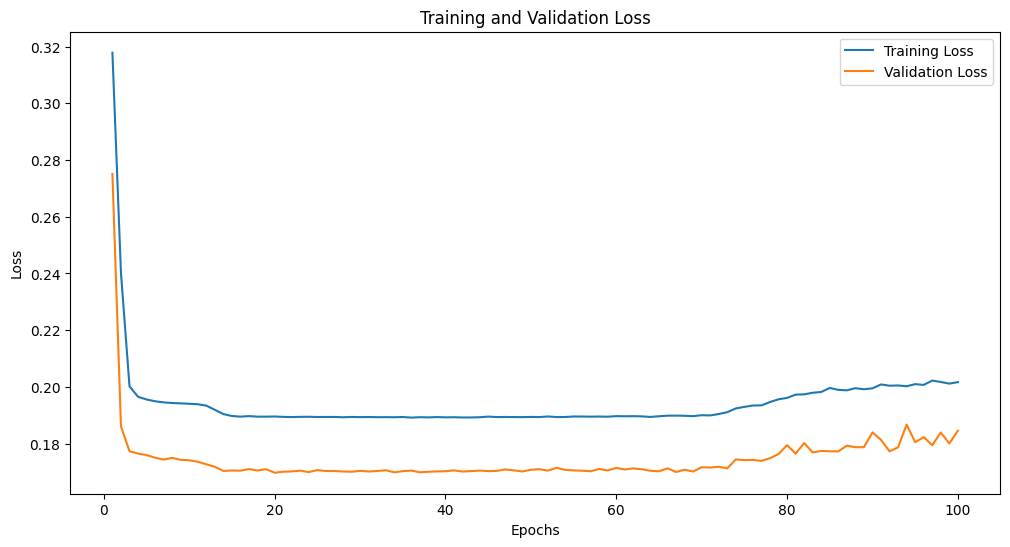

In [34]:
epochs = range(1, 101)

plt.figure(figsize=(12,6))
plt.plot(epochs, recon_train_loss, label='Training Loss')
plt.plot(epochs, recon_val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend(loc='best')
plt.show()

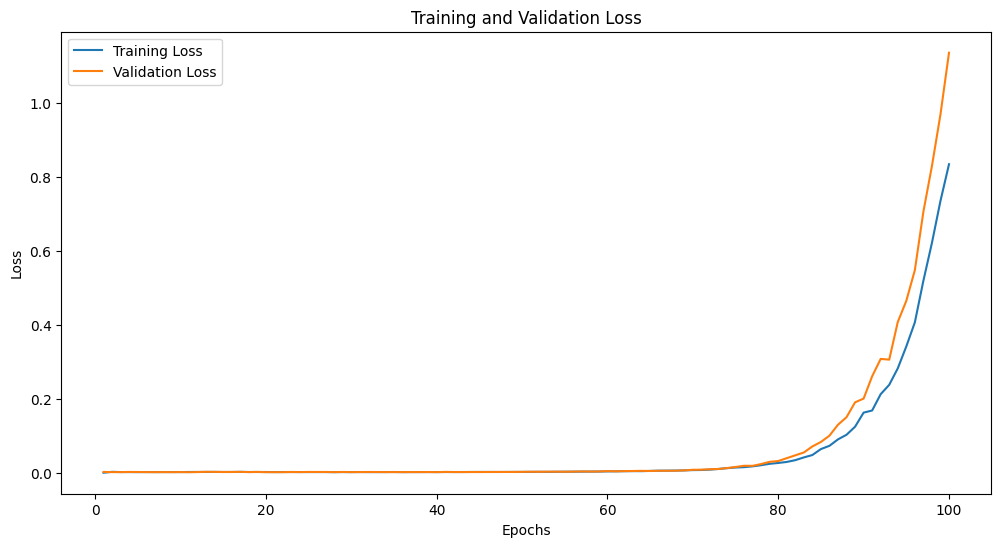

In [35]:
epochs = range(1, 101)

plt.figure(figsize=(12,6))
plt.plot(epochs, commit_train_loss, label='Training Loss')
plt.plot(epochs, commit_val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend(loc='best')
plt.show()

In [36]:
df.labels.value_counts()

labels
405    718
157    629
807    533
474    523
424    439
970    408
20     294
535    100
491     16
Name: count, dtype: int64

In [40]:
LABEL = 20
for rec in tqdm(df[df['labels'] == LABEL].to_dict(orient='records')):
    # save frame video to disk
    video = rec['videos'].split('.')[0]
    video_path = f"dataset/corpus/{video}.mp4"
    start_idx = rec['start_idx']
    end_idx = rec['end_idx']
    label = rec['labels']

    cap = cv2.VideoCapture(video_path)
    print(video_path)

    if not os.path.exists(f'analyze/quantization/{label}'):
        os.mkdir(f'analyze/quantization/{label}')

    FRAMES = []
    MAX = max(df[df['labels'] == LABEL]['end_idx'])
    for i in range(MAX):
        ret, frame = cap.read()
        if i >= start_idx and i <= end_idx:
            FRAMES.append(frame)

    # write frames to video
    out = cv2.VideoWriter(f'analyze/quantization/{label}/{video}_{start_idx}_{end_idx}.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (frame.shape[1], frame.shape[0]))
    for frame in FRAMES:
        out.write(frame)

    out.release()

  0%|          | 0/294 [00:00<?, ?it/s]

dataset/corpus/C╠ğES╠ğIT_0.mp4


AttributeError: 'NoneType' object has no attribute 'shape'